# TP - Entrega 2

In [516]:
%pip install -q pandas numpy matplotlib seaborn pandasql lightgbm scikit-learn

import numpy as np
import pandas as pd
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt

from pandasql import sqldf
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\carlo\AppData\Local\Programs\Python\Python313\python.exe -m pip install --upgrade pip


In [517]:
file_path = 'data_limpia.csv'
data = pd.read_csv(file_path, sep='|', dtype = {'client_id': 'str'})
print(data.head(10))

  client_id  Target       Month First_product_dt Last_product_dt  \
0   5856970     1.0  2018-10-01       2013-10-23      2019-01-10   
1   6371753     0.0  2018-09-01       2015-07-29      2018-06-02   
2   5928737     0.0  2019-01-01       2016-08-31      2018-12-27   
3    475064     0.0  2018-12-01       2014-07-13      2017-11-30   
4   3615172     0.0  2018-09-01       2017-12-27      2017-12-28   
5   6412264     0.0  2018-09-01       2016-01-27      2019-01-03   
6   6318899     0.0  2018-10-01       2015-03-26      2018-01-31   
7   7272795     1.0  2018-10-01       2018-04-23      2018-04-24   
8   4976363     0.0  2019-02-01       2013-12-05      2017-01-31   
9   5775560     0.0  2019-04-01       2013-08-22      2014-08-01   

  CreditCard_Premium CreditCard_Active CreditCard_CoBranding Loan_Active  \
0                 No               Yes                    No          No   
1                 No                No                    No          No   
2                 No   

In [518]:
data.shape

(238615, 77)

In [519]:
data.columns

Index(['client_id', 'Target', 'Month', 'First_product_dt', 'Last_product_dt',
       'CreditCard_Premium', 'CreditCard_Active', 'CreditCard_CoBranding',
       'Loan_Active', 'Mortgage_Active', 'SavingAccount_Active_ARG_Salary',
       'SavingAccount_Active_ARG', 'SavingAccount_Active_DOLLAR',
       'DebitCard_Active', 'Investment_Active', 'Package_Active',
       'Insurance_Life', 'Insurance_Home', 'Insurance_Accidents',
       'Insurance_Mobile', 'Insurance_ATM', 'Insurance_Unemployment', 'Sex',
       'Client_Age_grp', 'SavingAccount_Balance_FirstDate',
       'SavingAccount_Balance_LastDate', 'SavingAccount_Balance_Average',
       'SavingAccount_Days_with_use', 'SavingAccount_Days_with_Credits',
       'SavingAccount_Days_with_Debits',
       'SavingAccount_Salary_Payment_Transactions',
       'SavingAccount_Transfer_In_Transactions',
       'SavingAccount_ATM_Extraction_Transactions',
       'SavingAccount_Service_Payment_Transactions',
       'SavingAccount_CreditCard_Payment_T

In [520]:
print(data['Month'].dtype)
data['Month'].value_counts()

object


Month
2019-03-01    26547
2019-04-01    26547
2019-02-01    26512
2019-01-01    26503
2018-08-01    26502
2018-10-01    26501
2018-09-01    26501
2018-12-01    26501
2018-11-01    26501
Name: count, dtype: int64

In [521]:
data['periodo'] = pd.to_datetime(data['Month']).dt.strftime('%Y%m').astype(int)
data['periodo'].value_counts()

periodo
201903    26547
201904    26547
201902    26512
201901    26503
201808    26502
201810    26501
201809    26501
201812    26501
201811    26501
Name: count, dtype: int64

## Use Case 7: Manejo de Valores Faltantes

Identificación y tratamiento de valores nulos en el dataset.

In [522]:
data.columns[data.isnull().any()].tolist()

['SavingAccount_Balance_Average', 'Region', 'CreditCard_Product']

### Limpieza de Producto y Región

Tratamiento de valores faltantes en `CreditCard_Product` y `Region`. Estos campos no varían en el tiempo, por lo que se pueden completar utilizando la moda por cliente.

In [523]:
for col in ['CreditCard_Product', 'Region']:
    data[col] = data[col].replace('', np.nan)

In [524]:
print("Nulos restantes (Product):", data['CreditCard_Product'].isna().sum())
print("Nulos restantes (Region):", data['Region'].isna().sum())

Nulos restantes (Product): 201979
Nulos restantes (Region): 185535


In [525]:
def mode_nonnull(s: pd.Series):
    vc = s.dropna().value_counts()
    return vc.index[0] if len(vc) else np.nan

prod_mode = data.groupby('client_id')['CreditCard_Product'].apply(mode_nonnull)
data['CreditCard_Product'] = data['CreditCard_Product'].fillna(data['client_id'].map(prod_mode))

reg_mode = data.groupby('client_id')['Region'].apply(mode_nonnull)
data['Region'] = data['Region'].fillna(data['client_id'].map(reg_mode))


In [526]:
print("Nulos restantes (Product):", data['CreditCard_Product'].isna().sum())
print("Nulos restantes (Region):", data['Region'].isna().sum())

Nulos restantes (Product): 73724
Nulos restantes (Region): 104


In [527]:
data['CreditCard_Product'].value_counts(dropna=False)

CreditCard_Product
J55660104XX012    77924
NaN               73724
J55660202XX012    54218
J55660124XX012    22386
J55660102XX012     3753
J55660123XX012     3429
J55660702XX012     2574
J55661002XX012      607
Name: count, dtype: int64

In [528]:
clientes_todo_nan = data.groupby('client_id')['CreditCard_Product'].apply(lambda s: s.isna().all()).sum()
print(f"Clientes sin producto en ningún periodo: {clientes_todo_nan}")

Clientes sin producto en ningún periodo: 8214


In [529]:
clientes_sin_producto = (
    data.groupby('client_id')['CreditCard_Product']
    .apply(lambda s: s.isna().all())
)

clientes_sin_producto = clientes_sin_producto[clientes_sin_producto].index.tolist()

print(f"Total clientes sin producto en ningún período: {len(clientes_sin_producto)}")
print("Ejemplo de algunos IDs:", clientes_sin_producto[:10])

Total clientes sin producto en ningún período: 8214
Ejemplo de algunos IDs: ['1000199', '1000245', '1000847', '1001906', '100226', '1007730', '1007830', '1008223', '1008775', '1009217']


In [530]:
data[data['client_id'] == '5707524']

,client_id,Target,Month,First_product_dt,Last_product_dt,CreditCard_Premium,CreditCard_Active,CreditCard_CoBranding,Loan_Active,Mortgage_Active,...,CreditCard_Payment_Cash,CreditCard_Payment_Web,CreditCard_Payment_ATM,CreditCard_Payment_TAS,Investment_Numbers,Mobile,Email,Region,CreditCard_Product,periodo
76,5707524,0.0,2018-12-01,2013-04-17,2017-05-18,No,Yes,No,No,No,...,0.0,0.0,0.0,0.0,0.0,Yes,Yes,BUENOS AIRES,NaN,201812
17170,5707524,0.0,2018-10-01,2013-04-17,2017-05-18,No,Yes,No,No,No,...,0.0,0.0,0.0,0.0,0.0,Yes,Yes,BUENOS AIRES,NaN,201810
39783,5707524,0.0,2018-09-01,2013-04-17,2017-05-18,No,Yes,No,No,No,...,0.0,0.0,0.0,0.0,0.0,Yes,Yes,BUENOS AIRES,NaN,201809
50993,5707524,0.0,2018-11-01,2013-04-17,2017-05-18,No,Yes,No,No,No,...,0.0,0.0,0.0,0.0,0.0,Yes,Yes,BUENOS AIRES,NaN,201811
107005,5707524,0.0,2019-01-01,2013-04-17,2017-05-18,No,Yes,No,No,No,...,0.0,0.0,0.0,0.0,0.0,Yes,Yes,BUENOS AIRES,NaN,201901
116108,5707524,0.0,2019-04-01,2013-04-17,2017-05-18,No,No,No,No,No,...,0.0,0.0,0.0,0.0,0.0,Yes,Yes,BUENOS AIRES,NaN,201904
210374,5707524,0.0,2019-02-01,2013-04-17,2017-05-18,No,Yes,No,No,No,...,0.0,0.0,0.0,0.0,0.0,Yes,Yes,BUENOS AIRES,NaN,201902
217949,5707524,0.0,2018-08-01,2013-04-17,2017-05-18,No,Yes,No,No,No,...,0.0,0.0,0.0,0.0,0.0,Yes,Yes,BUENOS AIRES,NaN,201808
225414,5707524,0.0,2019-03-01,2013-04-17,2017-05-18,No,No,No,No,No,...,0.0,0.0,0.0,0.0,0.0,Yes,Yes,BUENOS AIRES,NaN,201903


In [531]:
cond = data['CreditCard_Product'].isna()
no_coinciden = data.loc[cond & (data['CreditCard_Active'] != 'No')]

print(f"Filas con producto nulo pero CreditCard_Active distinto de 'No': {len(no_coinciden)}")
no_coinciden.head()

Filas con producto nulo pero CreditCard_Active distinto de 'No': 2122


,client_id,Target,Month,First_product_dt,Last_product_dt,CreditCard_Premium,CreditCard_Active,CreditCard_CoBranding,Loan_Active,Mortgage_Active,...,CreditCard_Payment_Cash,CreditCard_Payment_Web,CreditCard_Payment_ATM,CreditCard_Payment_TAS,Investment_Numbers,Mobile,Email,Region,CreditCard_Product,periodo
76,5707524,0.0,2018-12-01,2013-04-17,2017-05-18,No,Yes,No,No,No,...,0.0,0.0,0.0,0.0,0.0,Yes,Yes,BUENOS AIRES,NaN,201812
253,7278197,0.0,2018-10-01,2018-04-29,2018-07-14,No,Yes,No,No,No,...,0.0,0.0,0.0,0.0,0.0,Yes,Yes,BUENOS AIRES,NaN,201810
258,5868104,0.0,2019-02-01,2014-04-08,2017-03-21,No,Yes,No,No,No,...,0.0,0.0,0.0,0.0,0.0,Yes,Yes,REGION NORTE GRANDE ARGENTINO,NaN,201902
287,4685382,0.0,2018-12-01,2018-03-14,2018-12-27,No,Yes,No,No,Yes,...,0.0,0.0,0.0,0.0,0.0,Yes,Yes,REGION NORTE GRANDE ARGENTINO,NaN,201812
460,1834285,0.0,2018-12-01,2009-04-19,2018-12-03,No,Yes,No,No,No,...,0.0,1.0,0.0,0.0,0.0,Yes,Yes,REGION CENTRO,NaN,201812


### Caso Especial: Clientes con Tarjeta Activa pero sin Producto

Se identificaron clientes con tarjeta de crédito activa pero sin producto asignado en ningún período. Para estos casos, se asignará el producto más común del dataset.

In [532]:
most_common_product = data['CreditCard_Product'].mode(dropna=True)[0]
print("Producto más frecuente:", most_common_product)


Producto más frecuente: J55660104XX012


In [533]:
clientes_con_tarjeta_sin_producto = (
    data.groupby('client_id')
        .apply(lambda g: (g['CreditCard_Active'].eq('Yes').any()) and g['CreditCard_Product'].isna().all())
)

clientes_con_tarjeta_sin_producto = clientes_con_tarjeta_sin_producto[clientes_con_tarjeta_sin_producto].index
print(f"Clientes con tarjeta activa pero sin producto asignado: {len(clientes_con_tarjeta_sin_producto)}")


Clientes con tarjeta activa pero sin producto asignado: 341


C:\Users\carlo\AppData\Local\Temp\ipykernel_29192\3888289581.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g['CreditCard_Active'].eq('Yes').any()) and g['CreditCard_Product'].isna().all())


In [534]:
mask = data['client_id'].isin(clientes_con_tarjeta_sin_producto)
data.loc[mask, 'CreditCard_Product'] = data.loc[mask, 'CreditCard_Product'].fillna(most_common_product)


In [535]:
cond = data['CreditCard_Product'].isna()
no_coinciden = data.loc[cond & (data['CreditCard_Active'] != 'No')]

print(f"Filas con producto nulo pero CreditCard_Active distinto de 'No': {len(no_coinciden)}")
no_coinciden.head()


Filas con producto nulo pero CreditCard_Active distinto de 'No': 0


,client_id,Target,Month,First_product_dt,Last_product_dt,CreditCard_Premium,CreditCard_Active,CreditCard_CoBranding,Loan_Active,Mortgage_Active,...,CreditCard_Payment_Cash,CreditCard_Payment_Web,CreditCard_Payment_ATM,CreditCard_Payment_TAS,Investment_Numbers,Mobile,Email,Region,CreditCard_Product,periodo


In [536]:
data['CreditCard_Product'] = data['CreditCard_Product'].fillna('SIN_PRODUCTO')

### Completado de Región

Para los valores faltantes de región, se utiliza la región más común del dataset.

In [537]:
most_common_region = data['Region'].mode(dropna=True)[0]
print("Region más frecuente:", most_common_region)


Region más frecuente: BUENOS AIRES


In [538]:
data['Region'] = data['Region'].fillna(most_common_region)
print("Nulos restantes (Region):", data['Region'].isna().sum())

Nulos restantes (Region): 0


### Completado de SavingAccount_Balance_Average

Para los valores faltantes, se utiliza el promedio entre el balance de la primera y última fecha.

In [539]:
cond = data['SavingAccount_Balance_Average'].isna()
print(f"Filas con SavingAccount_Balance_Average = NaN: {cond.sum()}")
data[cond].head()

Filas con SavingAccount_Balance_Average = NaN: 5


,client_id,Target,Month,First_product_dt,Last_product_dt,CreditCard_Premium,CreditCard_Active,CreditCard_CoBranding,Loan_Active,Mortgage_Active,...,CreditCard_Payment_Cash,CreditCard_Payment_Web,CreditCard_Payment_ATM,CreditCard_Payment_TAS,Investment_Numbers,Mobile,Email,Region,CreditCard_Product,periodo
81353,4473325,0.0,2018-12-01,2008-05-27,2017-05-18,Yes,Yes,No,No,No,...,0.0,0.0,0.0,0.0,0.0,Yes,Yes,AMBA Resto,J55660104XX012,201812
81354,4837071,1.0,2018-12-01,2013-02-21,2018-09-04,No,No,No,No,No,...,0.0,0.0,0.0,0.0,0.0,Yes,Yes,REGION CUYO,SIN_PRODUCTO,201812
81356,4525957,1.0,2019-01-01,2012-10-16,2016-08-31,Yes,Yes,No,No,No,...,0.0,1.0,0.0,0.0,0.0,Yes,Yes,CABA Centro/Norte,J55661002XX012,201901
81361,4842337,1.0,2019-02-01,2010-07-27,2018-07-06,No,Yes,No,Yes,No,...,0.0,0.0,0.0,0.0,0.0,Yes,Yes,BUENOS AIRES,J55660202XX012,201902
238612,6412619,0.0,2019-01-01,2015-07-08,2018-06-02,No,No,No,Yes,No,...,0.0,0.0,0.0,0.0,0.0,Yes,No,REGION PATAGONICA,SIN_PRODUCTO,201901


In [540]:
mask = data['SavingAccount_Balance_Average'].isna()

data.loc[mask, 'SavingAccount_Balance_Average'] = (
    (data.loc[mask, 'SavingAccount_Balance_FirstDate'] +
     data.loc[mask, 'SavingAccount_Balance_LastDate']) / 2
)

In [541]:
cond = data['SavingAccount_Balance_Average'].isna()

print(f"Filas con SavingAccount_Balance_Average = NaN: {cond.sum()}")
data[cond].head()

Filas con SavingAccount_Balance_Average = NaN: 0


,client_id,Target,Month,First_product_dt,Last_product_dt,CreditCard_Premium,CreditCard_Active,CreditCard_CoBranding,Loan_Active,Mortgage_Active,...,CreditCard_Payment_Cash,CreditCard_Payment_Web,CreditCard_Payment_ATM,CreditCard_Payment_TAS,Investment_Numbers,Mobile,Email,Region,CreditCard_Product,periodo


In [542]:
cols = [
    'client_id', 'periodo',
    'SavingAccount_Balance_FirstDate',
    'SavingAccount_Total_Amount',
    'SavingAccount_Balance_Average'
]

data.loc[(data['client_id'] == '4837071') & (data['periodo'] == 201812), cols]


,client_id,periodo,SavingAccount_Balance_FirstDate,SavingAccount_Total_Amount,SavingAccount_Balance_Average
81354,4837071,201812,43.53,21364.52,5325.79


In [543]:
data.columns[data.isnull().any()].tolist()

[]

In [544]:
data.shape

(238615, 78)

## Use Case 1: Selección de Clientes con 9 Meses de Datos

Se filtran únicamente los clientes que tienen datos completos para los 9 meses del período de análisis. Esto garantiza consistencia en el análisis temporal.


In [545]:
client_period_counts = data.groupby('client_id')['periodo'].nunique()
client_period_counts

client_id
1000199    9
1000245    9
1000847    9
1001232    9
1001450    9
          ..
99842      9
998420     9
998768     9
99926      9
999462     9
Name: periodo, Length: 26560, dtype: int64

In [546]:
expected_months = data['periodo'].nunique()
expected_months

9

In [547]:
g = (data.groupby(['client_id','periodo'])
         .size()
         .reset_index(name='rows_per_month'))
g

,client_id,periodo,rows_per_month
0,1000199,201808,1
1,1000199,201809,1
2,1000199,201810,1
3,1000199,201811,1
4,1000199,201812,1
...,...,...,...
238610,999462,201812,1
238611,999462,201901,1
238612,999462,201902,1
238613,999462,201903,1


In [548]:
g1 = g[g['rows_per_month'] == 1]
g1

,client_id,periodo,rows_per_month
0,1000199,201808,1
1,1000199,201809,1
2,1000199,201810,1
3,1000199,201811,1
4,1000199,201812,1
...,...,...,...
238610,999462,201812,1
238611,999462,201901,1
238612,999462,201902,1
238613,999462,201903,1


In [549]:
valid_clients = (g1.groupby('client_id')['periodo']
                   .nunique()
                   .pipe(lambda s: s[s == expected_months])
                   .index)
valid_clients

Index(['1000199', '1000245', '1000847', '1001232', '1001450', '1001906',
       '100226', '1002452', '1002681', '1002739',
       ...
       '997539', '997836', '9982', '998375', '998377', '99842', '998420',
       '998768', '99926', '999462'],
      dtype='object', name='client_id', length=26483)

In [550]:
clientes_9m = list(valid_clients)

In [551]:
cantidad_clientes_9m = len(valid_clients)
cantidad_clientes_9m

26483

In [552]:
data_9m = data[data['client_id'].isin(valid_clients)]

In [553]:
data_9m

,client_id,Target,Month,First_product_dt,Last_product_dt,CreditCard_Premium,CreditCard_Active,CreditCard_CoBranding,Loan_Active,Mortgage_Active,...,CreditCard_Payment_Cash,CreditCard_Payment_Web,CreditCard_Payment_ATM,CreditCard_Payment_TAS,Investment_Numbers,Mobile,Email,Region,CreditCard_Product,periodo
0,5856970,1.0,2018-10-01,2013-10-23,2019-01-10,No,Yes,No,No,No,...,0.0,0.0,0.0,0.0,1.0,Yes,Yes,AMBA Resto,J55660202XX012,201810
1,6371753,0.0,2018-09-01,2015-07-29,2018-06-02,No,No,No,No,No,...,0.0,0.0,0.0,0.0,0.0,Yes,No,REGION CENTRO,SIN_PRODUCTO,201809
2,5928737,0.0,2019-01-01,2016-08-31,2018-12-27,No,No,No,No,No,...,0.0,0.0,0.0,0.0,0.0,Yes,Yes,REGION NORTE GRANDE ARGENTINO,SIN_PRODUCTO,201901
3,475064,0.0,2018-12-01,2014-07-13,2017-11-30,No,Yes,No,No,No,...,0.0,0.0,0.0,0.0,0.0,Yes,Yes,REGION CUYO,J55660202XX012,201812
4,3615172,0.0,2018-09-01,2017-12-27,2017-12-28,No,No,No,No,No,...,0.0,0.0,0.0,0.0,0.0,Yes,No,REGION CENTRO,SIN_PRODUCTO,201809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238610,6448833,0.0,2019-03-01,2016-05-09,2019-04-02,No,No,No,No,No,...,0.0,0.0,0.0,0.0,0.0,Yes,Yes,REGION NORTE GRANDE ARGENTINO,SIN_PRODUCTO,201903
238611,6377583,0.0,2019-04-01,2015-06-03,2019-01-04,No,Yes,No,Yes,No,...,0.0,0.0,0.0,0.0,0.0,Yes,Yes,BUENOS AIRES,J55660104XX012,201904
238612,6412619,0.0,2019-01-01,2015-07-08,2018-06-02,No,No,No,Yes,No,...,0.0,0.0,0.0,0.0,0.0,Yes,No,REGION PATAGONICA,SIN_PRODUCTO,201901
238613,5542402,0.0,2019-04-01,2012-09-13,2012-09-13,No,Yes,No,No,No,...,0.0,0.0,1.0,0.0,0.0,No,Yes,REGION NORTE GRANDE ARGENTINO,J55660104XX012,201904


In [554]:
client_counts = data_9m['client_id'].value_counts().reset_index()
client_counts.columns = ['client_id', 'meses']

In [555]:
client_counts

,client_id,meses
0,5856970,9
1,6371753,9
2,5928737,9
3,475064,9
4,3615172,9
...,...,...
26478,1988103,9
26479,4908119,9
26480,5744054,9
26481,3028372,9


## Filtrado Adicional: Clientes sin Paquete Activo

Se filtran los clientes que no tienen paquete activo en el mes de referencia (201901). Este filtro se aplica considerando el período temporal.

In [556]:
data['Package_Active'].value_counts()

Package_Active
No     234177
Yes      4438
Name: count, dtype: int64

In [557]:
data_sinPaquete = data[(data['Package_Active'] == 'No') & (data['periodo'] == 201901)][['client_id']]
data_sinPaquete

,client_id
2,5928737
10,6018047
11,5359038
16,6890812
20,115383
...,...
238573,6570413
238574,6258895
238585,6397274
238586,6007291


In [558]:
### Filtrado: Sin Co-branding

#Se filtran los clientes que no tienen tarjeta de crédito con co-branding activo.

data['CreditCard_CoBranding'].value_counts()

CreditCard_CoBranding
No     213049
Yes     25566
Name: count, dtype: int64

In [559]:
data_cobranding = data[(data['CreditCard_CoBranding'] == 'No') & (data['periodo'] == 201901)][['client_id']]
data_cobranding

,client_id
2,5928737
10,6018047
11,5359038
16,6890812
20,115383
...,...
238573,6570413
238574,6258895
238585,6397274
238586,6007291


In [560]:
### Consolidación de Filtros

#Se combinan todos los filtros aplicados para obtener el conjunto final de clientes elegibles.

data_final = client_counts.merge(data_sinPaquete, how='inner', on='client_id')\
                     .merge(data_cobranding, how='inner', on='client_id')

data_final.shape

(23191, 2)

In [561]:
data_final

,client_id,meses
0,5856970,9
1,6371753,9
2,5928737,9
3,475064,9
4,3615172,9
...,...,...
23186,4221845,9
23187,1988103,9
23188,4908119,9
23189,3028372,9


## Use Case 2: Definición de Ventanas Temporales

- **Ventana de Predicción (Prediction Window)**: Últimos 2 meses (201903, 201904)
- **Ventana de Lead (Lead Window)**: 1 mes (201902)
- **Ventana Histórica (Historical Window)**: Resto de los meses (201808-201901)

In [562]:
train_window = [201808, 201809, 201810, 201811, 201812, 201901]
train_end = 201901
lead_month = 201902
pred_window = [201903, 201904]

data_TGT = data[data['periodo'].isin(pred_window)][['client_id', 'Target']]
data_TGT.client_id.value_counts()

client_id
6867662    2
5775560    2
5800470    2
3540244    2
2739521    2
          ..
672542     1
264018     1
6884923    1
6393208    1
4424661    1
Name: count, Length: 26551, dtype: int64

In [563]:
data_TGT = data[(data['periodo'].isin(pred_window)) & (data['Target'] == 1)][['client_id']].drop_duplicates()
data_TGT.client_id.value_counts()

client_id
5025967    1
937183     1
2799736    1
5425606    1
1809861    1
          ..
786498     1
6937189    1
6861415    1
938881     1
943184     1
Name: count, Length: 6926, dtype: int64

In [564]:
data_TGT['TGT'] = 1

# Drop the existing 'TGT' column from data_final before merging
if 'TGT' in data_final.columns:
  data_final = data_final.drop('TGT', axis=1)

data_final = data_final.merge(data_TGT, how='left', on='client_id')

data_final['TGT'] = data_final['TGT'].fillna(0)

In [565]:
data_final['TGT'].value_counts()

TGT
0.0    16368
1.0     6823
Name: count, dtype: int64

In [566]:
data_trainWindow = data[data['periodo'].isin(train_window)]
len(data_trainWindow['client_id'].unique())

26509

In [567]:
data_trainWindow = data_trainWindow.merge(data_final[['client_id']], how='inner', on='client_id')
len(data_trainWindow['client_id'].unique())

23191

In [568]:
data_trainWindow['periodo'].value_counts().sort_index()

periodo
201808    23191
201809    23191
201810    23191
201811    23191
201812    23191
201901    23191
Name: count, dtype: int64

In [569]:
data_trainWindow.shape

(139146, 78)

In [570]:
data_trainWindow['SavingAccount_Active_ARG'].value_counts()

SavingAccount_Active_ARG
Yes    101033
No      38113
Name: count, dtype: int64

## Use Case 3: Análisis de Balance del Target

Análisis de la distribución del target para determinar si está balanceado o desbalanceado. Si está desbalanceado, se pueden aplicar técnicas de balanceo para alcanzar una distribución 50/50.

In [571]:
# Mostrar el balance de la base
porcentajes = (
    data.groupby(['periodo', 'Target'])
    .size()
    .reset_index(name='count')
)

porcentajes['total_periodo'] = porcentajes.groupby('periodo')['count'].transform('sum')

porcentajes['porcentaje'] = (porcentajes['count'] / porcentajes['total_periodo']) * 100

porcentajes # Si esta balanceada la base, tiene mas o menos 26% todos los meses. Para balancearlo 50/50 se podria agarrar muestras aleatorias del 74% hasta reducirlo hasta que quede una base de 50%, procurando mantener clientes que tengamos 9 meses de datos.

,periodo,Target,count,total_periodo,porcentaje
0,201808,0.0,19587,26502,73.907630
1,201808,1.0,6915,26502,26.092370
2,201809,0.0,19586,26501,73.906645
3,201809,1.0,6915,26501,26.093355
4,201810,0.0,19586,26501,73.906645
5,201810,1.0,6915,26501,26.093355
6,201811,0.0,19586,26501,73.906645
7,201811,1.0,6915,26501,26.093355
8,201812,0.0,19586,26501,73.906645
9,201812,1.0,6915,26501,26.093355


## Use Case 4: Identificación de Tipos de Datos

Análisis de los tipos de datos de las columnas en el dataset para determinar el tratamiento adecuado de cada variable.

In [572]:
data_trainWindow.dtypes

client_id              object
Target                float64
Month                  object
First_product_dt       object
Last_product_dt        object
                       ...   
Mobile                 object
Email                  object
Region                 object
CreditCard_Product     object
periodo                 int64
Length: 78, dtype: object

## Use Case 8: Análisis de Outliers

Análisis de valores atípicos en `SavingAccount_Balance_Average` y aplicación de la misma metodología a otras características numéricas del dataset.

#SavingAccount_Balance_Average

In [573]:
# Outliers

data_trainWindow[['SavingAccount_Balance_Average'] ].describe()

,SavingAccount_Balance_Average
count,1.391460e+05
mean,4.094833e+03
std,2.293939e+04
min,-5.665900e+02
25%,0.000000e+00
50%,1.032500e+01
75%,1.473138e+03
max,1.771201e+06


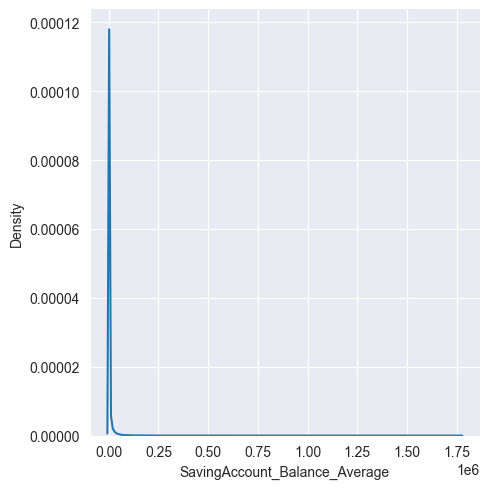

In [574]:
# plot a distribution plot
sns.displot(data_trainWindow['SavingAccount_Balance_Average'], kind='kde')

# display the plot
plt.show()

In [575]:
# 3 sigmas

three_sigma = 3 * data_trainWindow['SavingAccount_Balance_Average'].std()
three_sigma

np.float64(68818.15942060263)

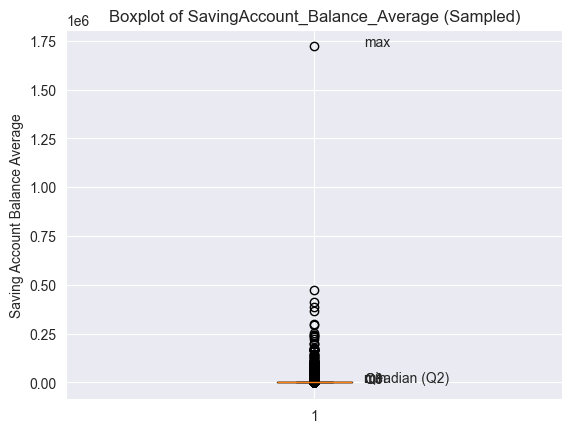

In [576]:
# Box Plot

# Sample the data to avoid plotting too many points
sample_size = 10000  # You can adjust this number as needed
sampled_data = data_trainWindow['SavingAccount_Balance_Average'].sample(n=sample_size, random_state=42)

plt.boxplot(sampled_data)

# add labels for five number summary
plt.text(x = 1.1, y = sampled_data.min(), s ='min')
plt.text(x = 1.1, y = sampled_data.quantile(0.25), s ='Q1')
plt.text(x = 1.1, y = sampled_data.median(), s ='meadian (Q2)')
plt.text(x = 1.1, y = sampled_data.quantile(0.75), s ='Q3')
plt.text(x = 1.1, y = sampled_data.max(), s ='max')


# add the graph title and axes labels
plt.title('Boxplot of SavingAccount_Balance_Average (Sampled)')
plt.ylabel('Saving Account Balance Average')

# display the plot
plt.show()

In [577]:
Q1 = data_trainWindow['SavingAccount_Balance_Average'].quantile(0.25)
Q3 = data_trainWindow['SavingAccount_Balance_Average'].quantile(0.75)

print('Todo lo que sea mayor a ' , Q3 + (1.5 * (Q3 - Q1)), ' es un outlier')

Todo lo que sea mayor a  3682.84375  es un outlier


In [578]:
print('Todo lo que sea mayor a ' , data_trainWindow['SavingAccount_Balance_Average'].quantile(0.95) , ' es un outlier')

Todo lo que sea mayor a  17043.66  es un outlier


In [579]:
outlier = data_trainWindow['SavingAccount_Balance_Average'].quantile(0.99)

data_trainWindow['SavingAccount_Balance_Average'] = np.where(data_trainWindow['SavingAccount_Balance_Average'] > outlier, outlier, data_trainWindow['SavingAccount_Balance_Average'] )

In [580]:
# 3 sigmas

three_sigma = 3 * data_trainWindow['SavingAccount_Balance_Average'].std()
three_sigma

np.float64(29717.142543139336)

In [581]:
data_trainWindow['SavingAccount_Balance_Average'] = np.where(data_trainWindow['SavingAccount_Balance_Average'] > three_sigma, three_sigma, data_trainWindow['SavingAccount_Balance_Average'] )

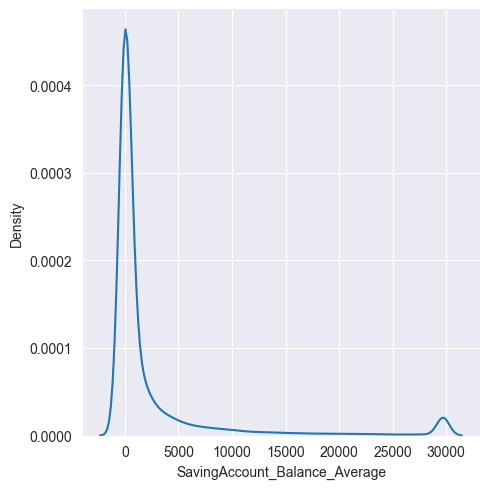

In [582]:
# plot a distribution plot
sns.displot(data_trainWindow['SavingAccount_Balance_Average'], kind='kde')

# display the plot
plt.show()

In [583]:
data_trainWindow['SavingAccount_Balance_Average'].describe()

count    139146.000000
mean       2508.848544
std        6226.592558
min        -566.590000
25%           0.000000
50%          10.325000
75%        1473.137500
max       29717.142543
Name: SavingAccount_Balance_Average, dtype: float64

#CreditCard_Total_Spending



In [584]:
# Outliers

data_trainWindow[['CreditCard_Total_Spending'] ].describe()

,CreditCard_Total_Spending
count,139146.00000
mean,4226.44988
std,7290.00507
min,-30164.77000
25%,0.00000
50%,1482.71000
75%,5656.14750
max,176554.25000


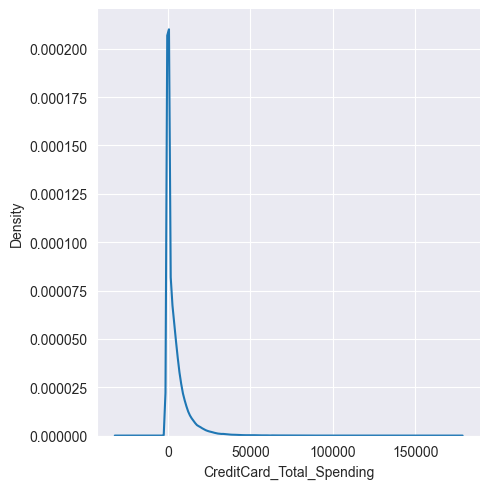

In [585]:
# plot a distribution plot
sns.displot(data_trainWindow['CreditCard_Total_Spending'], kind='kde')

# display the plot
plt.show()

In [586]:
# 3 sigmas

three_sigma = 3 * data_trainWindow['CreditCard_Total_Spending'].std()
three_sigma

np.float64(21870.01520929554)

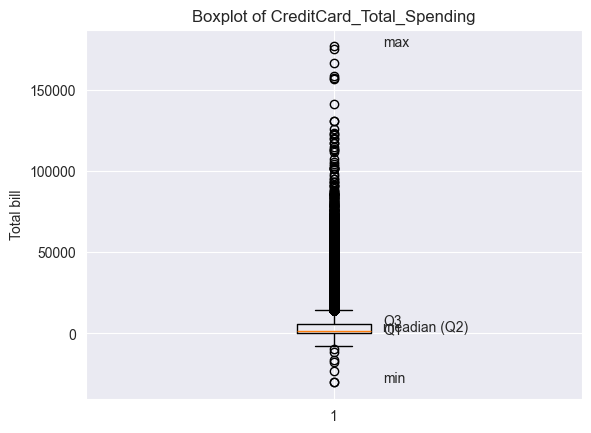

In [587]:
# Box Plot

plt.boxplot(data_trainWindow['CreditCard_Total_Spending'])

# add labels for five number summary
plt.text(x = 1.1, y = data_trainWindow['CreditCard_Total_Spending'].min(), s ='min')
plt.text(x = 1.1, y = data_trainWindow['CreditCard_Total_Spending'].quantile(0.25), s ='Q1')
plt.text(x = 1.1, y = data_trainWindow['CreditCard_Total_Spending'].median(), s ='meadian (Q2)')
plt.text(x = 1.1, y = data_trainWindow['CreditCard_Total_Spending'].quantile(0.75), s ='Q3')
plt.text(x = 1.1, y = data_trainWindow['CreditCard_Total_Spending'].max(), s ='max')


# add the graph title and axes labels
plt.title('Boxplot of CreditCard_Total_Spending')
plt.ylabel('Total bill')

# display the plot
plt.show()

In [588]:
Q1 = data_trainWindow['CreditCard_Total_Spending'].quantile(0.25)
Q3 = data_trainWindow['CreditCard_Total_Spending'].quantile(0.75)

print('Todo lo que sea mayor a ' , Q3 + (1.5 * (Q3 - Q1)), ' es un outlier')

Todo lo que sea mayor a  14140.368750000001  es un outlier


In [589]:
print('Todo lo que sea mayor a ' , data_trainWindow['CreditCard_Total_Spending'].quantile(0.95) , ' es un outlier')

Todo lo que sea mayor a  17131.6725  es un outlier


In [590]:
outlier = data_trainWindow['CreditCard_Total_Spending'].quantile(0.99)

data_trainWindow['CreditCard_Total_Spending'] = np.where(data_trainWindow['CreditCard_Total_Spending'] > outlier, outlier, data_trainWindow['CreditCard_Total_Spending'] )

In [591]:
# 3 sigmas

three_sigma = 3 * data_trainWindow['CreditCard_Total_Spending'].std()
three_sigma

np.float64(18749.021112125287)

In [592]:
data_trainWindow['CreditCard_Total_Spending'] = np.where(data_trainWindow['CreditCard_Total_Spending'] > three_sigma, three_sigma, data_trainWindow['CreditCard_Total_Spending'] )

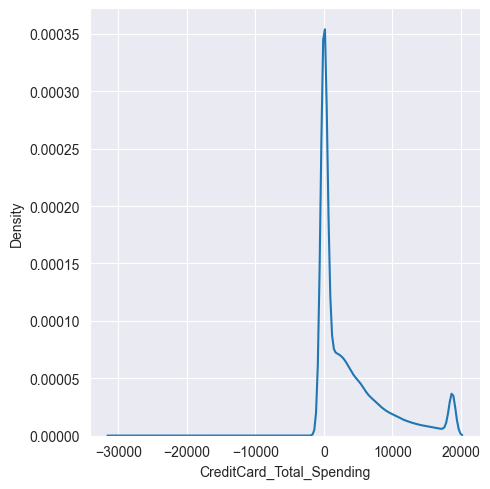

In [593]:
# plot a distribution plot
sns.displot(data_trainWindow['CreditCard_Total_Spending'], kind='kde')

# display the plot
plt.show()

In [594]:
#Revisamos los negativos

negativos_count = (data_trainWindow['CreditCard_Total_Spending'] < 0).sum()
print("Cantidad de filas con valores negativos:", negativos_count)

positivos_count = (data_trainWindow['CreditCard_Total_Spending'] >= 0).sum()
print("Cantidad de filas con valores positivos:", positivos_count)

Cantidad de filas con valores negativos: 62
Cantidad de filas con valores positivos: 139084


##reemplazo valores negativos con 3sigma

In [595]:
data_trainWindow['CreditCard_Total_Spending'] = np.where(data_trainWindow['CreditCard_Total_Spending'] < 0, three_sigma, data_trainWindow['CreditCard_Total_Spending'] )

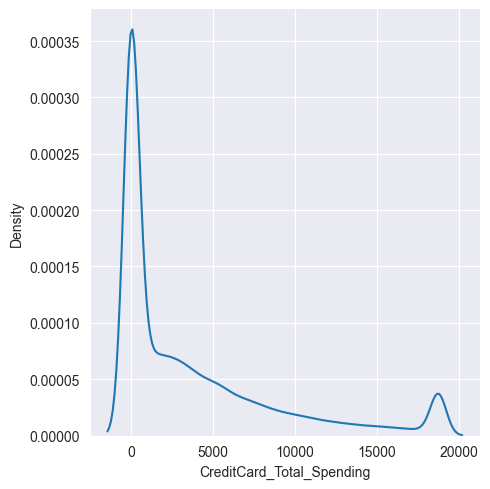

In [596]:
# plot a distribution plot
sns.displot(data_trainWindow['CreditCard_Total_Spending'], kind='kde')

# display the plot
plt.show()

In [597]:
data_trainWindow['CreditCard_Total_Spending'].describe()

count    139146.000000
mean       3781.875490
std        5170.601013
min           0.000000
25%           0.000000
50%        1488.460000
75%        5665.242500
max       18749.021112
Name: CreditCard_Total_Spending, dtype: float64

#SavingAccount_Days_with_use

In [598]:
# Outliers

data_trainWindow[['SavingAccount_Days_with_use'] ].describe()

,SavingAccount_Days_with_use
count,139146.000000
mean,2.512685
std,3.831400
min,0.000000
25%,0.000000
50%,0.000000
75%,4.000000
max,41.000000


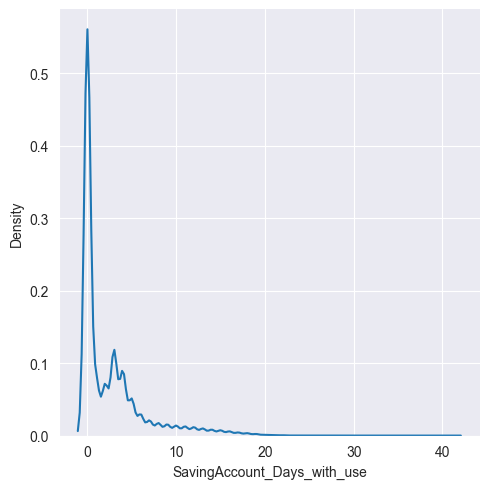

In [599]:
# plot a distribution plot
sns.displot(data_trainWindow['SavingAccount_Days_with_use'], kind='kde')

# display the plot
plt.show()

In [600]:
# 3 sigmas

three_sigma = 3 * data_trainWindow['SavingAccount_Days_with_use'].std()
three_sigma

np.float64(11.494198755310885)

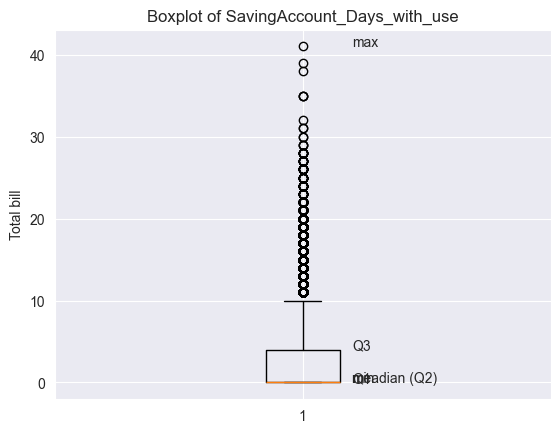

In [601]:
# Box Plot

plt.boxplot(data_trainWindow['SavingAccount_Days_with_use'])

# add labels for five number summary
plt.text(x = 1.1, y = data_trainWindow['SavingAccount_Days_with_use'].min(), s ='min')
plt.text(x = 1.1, y = data_trainWindow['SavingAccount_Days_with_use'].quantile(0.25), s ='Q1')
plt.text(x = 1.1, y = data_trainWindow['SavingAccount_Days_with_use'].median(), s ='meadian (Q2)')
plt.text(x = 1.1, y = data_trainWindow['SavingAccount_Days_with_use'].quantile(0.75), s ='Q3')
plt.text(x = 1.1, y = data_trainWindow['SavingAccount_Days_with_use'].max(), s ='max')


# add the graph title and axes labels
plt.title('Boxplot of SavingAccount_Days_with_use')
plt.ylabel('Total bill')

# display the plot
plt.show()

In [602]:
Q1 = data_trainWindow['SavingAccount_Days_with_use'].quantile(0.25)
Q3 = data_trainWindow['SavingAccount_Days_with_use'].quantile(0.75)

print('Todo lo que sea mayor a ' , Q3 + (1.5 * (Q3 - Q1)), ' es un outlier')

Todo lo que sea mayor a  10.0  es un outlier


In [603]:
print('Todo lo que sea mayor a ' , data_trainWindow['SavingAccount_Days_with_use'].quantile(0.92) , ' es un outlier')

Todo lo que sea mayor a  9.0  es un outlier


In [604]:
outlier = data_trainWindow['SavingAccount_Days_with_use'].quantile(0.99)

data_trainWindow['SavingAccount_Days_with_use'] = np.where(data_trainWindow['SavingAccount_Days_with_use'] > outlier, outlier, data_trainWindow['SavingAccount_Days_with_use'] )

In [605]:
# 3 sigmas

three_sigma = 3 * data_trainWindow['SavingAccount_Days_with_use'].std()
three_sigma

np.float64(11.229661310383698)

In [606]:
data_trainWindow['SavingAccount_Days_with_use'] = np.where(data_trainWindow['SavingAccount_Days_with_use'] > three_sigma, three_sigma, data_trainWindow['SavingAccount_Days_with_use'] )

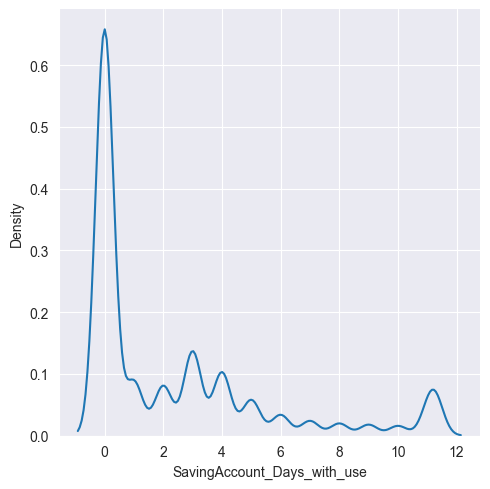

In [607]:
# plot a distribution plot
sns.displot(data_trainWindow['SavingAccount_Days_with_use'], kind='kde')

# display the plot
plt.show()

In [608]:
data_trainWindow['SavingAccount_Days_with_use'].describe()

count    139146.000000
mean          2.338040
std           3.257995
min           0.000000
25%           0.000000
50%           0.000000
75%           4.000000
max          11.229661
Name: SavingAccount_Days_with_use, dtype: float64

## Use Case 6: Ingeniería de Características

- Identificación de **Identity Features**: Características que no cambian en el tiempo
- Identificación de **Transform Features**: Características derivadas o transformadas
- Creación de DataFrame con características de identidad y transformadas

## Identity features

In [609]:
identity_cols = [
    'client_id',
    'CreditCard_Premium',
    'CreditCard_Active',
    'CreditCard_CoBranding',
    'Loan_Active',
    'Mortgage_Active',
    'SavingAccount_Active_ARG_Salary',
    'SavingAccount_Active_ARG',
    'SavingAccount_Active_DOLLAR',
    'DebitCard_Active',
    'Investment_Active',
    'Package_Active',
    'Insurance_Life',
    'Insurance_Home',
    'Insurance_Accidents',
    'Insurance_Mobile',
    'Insurance_ATM',
    'Insurance_Unemployment',
    'Sex',
    'Region',
    'CreditCard_Product',
    'Client_Age_grp' #No es identity
]

data_if = data_trainWindow[data_trainWindow['periodo'] == 201901][identity_cols]

In [610]:
data_if.columns

Index(['client_id', 'CreditCard_Premium', 'CreditCard_Active',
       'CreditCard_CoBranding', 'Loan_Active', 'Mortgage_Active',
       'SavingAccount_Active_ARG_Salary', 'SavingAccount_Active_ARG',
       'SavingAccount_Active_DOLLAR', 'DebitCard_Active', 'Investment_Active',
       'Package_Active', 'Insurance_Life', 'Insurance_Home',
       'Insurance_Accidents', 'Insurance_Mobile', 'Insurance_ATM',
       'Insurance_Unemployment', 'Sex', 'Region', 'CreditCard_Product',
       'Client_Age_grp'],
      dtype='object')

In [611]:
data_if.head(10)

,client_id,CreditCard_Premium,CreditCard_Active,CreditCard_CoBranding,Loan_Active,Mortgage_Active,SavingAccount_Active_ARG_Salary,SavingAccount_Active_ARG,SavingAccount_Active_DOLLAR,DebitCard_Active,...,Insurance_Life,Insurance_Home,Insurance_Accidents,Insurance_Mobile,Insurance_ATM,Insurance_Unemployment,Sex,Region,CreditCard_Product,Client_Age_grp
2,5928737,No,No,No,No,No,No,Yes,Yes,Yes,...,No,No,No,No,No,No,M,REGION NORTE GRANDE ARGENTINO,SIN_PRODUCTO,Entre 30 y 39 años
8,6018047,Yes,Yes,No,No,No,No,Yes,No,Yes,...,No,No,No,No,No,No,M,BUENOS AIRES,J55660104XX012,Entre 60 y 64 años
9,5359038,Yes,Yes,No,Yes,No,Yes,Yes,Yes,Yes,...,No,No,No,No,No,No,M,REGION NORTE GRANDE ARGENTINO,J55660104XX012,Entre 40 y 49 años
11,6890812,No,No,No,Yes,No,No,Yes,Yes,Yes,...,No,No,No,No,No,No,M,REGION NORTE GRANDE ARGENTINO,SIN_PRODUCTO,Entre 40 y 49 años
13,115383,No,No,No,No,No,No,Yes,No,No,...,No,No,No,No,No,No,M,AMBA Resto,SIN_PRODUCTO,Mayor a 70 años
20,625203,No,Yes,No,No,No,No,No,No,No,...,No,No,No,No,No,No,M,CABA Centro/Norte,J55660202XX012,Entre 50 y 59 años
21,6923877,No,Yes,No,No,No,No,Yes,No,Yes,...,No,No,No,No,No,No,F,BUENOS AIRES,J55660104XX012,Entre 50 y 59 años
34,6444332,No,Yes,No,No,No,No,Yes,Yes,Yes,...,No,No,No,No,No,No,F,BUENOS AIRES,J55660104XX012,Entre 30 y 39 años
35,4668933,No,No,No,No,No,No,Yes,Yes,Yes,...,No,No,No,No,No,No,F,AMBA Resto,SIN_PRODUCTO,Entre 40 y 49 años
36,4882755,No,No,No,No,No,No,Yes,Yes,Yes,...,No,No,No,No,No,No,M,CABA Centro/Norte,SIN_PRODUCTO,Entre 30 y 39 años


In [612]:
data_if.dtypes

client_id                          object
CreditCard_Premium                 object
CreditCard_Active                  object
CreditCard_CoBranding              object
Loan_Active                        object
Mortgage_Active                    object
SavingAccount_Active_ARG_Salary    object
SavingAccount_Active_ARG           object
SavingAccount_Active_DOLLAR        object
DebitCard_Active                   object
Investment_Active                  object
Package_Active                     object
Insurance_Life                     object
Insurance_Home                     object
Insurance_Accidents                object
Insurance_Mobile                   object
Insurance_ATM                      object
Insurance_Unemployment             object
Sex                                object
Region                             object
CreditCard_Product                 object
Client_Age_grp                     object
dtype: object

#

In [613]:
# Reemplazar False / True , No / Yes  por 0 y 1

In [614]:
# Solo columnas no numéricas
non_numeric_cols = data_if.select_dtypes(include=['object', 'bool']).columns

In [615]:
binary_cols = [
    col for col in non_numeric_cols
    if data_if[col].dropna().nunique() == 2
]

print("Columnas binarias (Yes/No o True/False):")
print(binary_cols)


Columnas binarias (Yes/No o True/False):
['CreditCard_Premium', 'CreditCard_Active', 'Loan_Active', 'Mortgage_Active', 'SavingAccount_Active_ARG_Salary', 'SavingAccount_Active_ARG', 'SavingAccount_Active_DOLLAR', 'DebitCard_Active', 'Investment_Active', 'Sex']


In [616]:
for col in binary_cols:
    print(f"{col}: {data_if[col].dropna().unique()}")

CreditCard_Premium: ['No' 'Yes']
CreditCard_Active: ['No' 'Yes']
Loan_Active: ['No' 'Yes']
Mortgage_Active: ['No' 'Yes']
SavingAccount_Active_ARG_Salary: ['No' 'Yes']
SavingAccount_Active_ARG: ['Yes' 'No']
SavingAccount_Active_DOLLAR: ['Yes' 'No']
DebitCard_Active: ['Yes' 'No']
Investment_Active: ['No' 'Yes']
Sex: ['M' 'F']


In [617]:
# columnas no numéricas
non_numeric = data_if.select_dtypes(include=['object','bool','category']).columns

binary_cols = []
for c in non_numeric:
    vals = (data_if[c]
            .dropna()
            .astype(str)
            .str.strip()
            .str.upper()
            .unique())
    if set(vals).issubset({'YES','NO','TRUE','FALSE','Y','N','0','1','M','F'}):
        binary_cols.append(c)

print("Binarias detectadas:", binary_cols)

Binarias detectadas: ['CreditCard_Premium', 'CreditCard_Active', 'CreditCard_CoBranding', 'Loan_Active', 'Mortgage_Active', 'SavingAccount_Active_ARG_Salary', 'SavingAccount_Active_ARG', 'SavingAccount_Active_DOLLAR', 'DebitCard_Active', 'Investment_Active', 'Package_Active', 'Insurance_Life', 'Insurance_Home', 'Insurance_Accidents', 'Insurance_Mobile', 'Insurance_ATM', 'Insurance_Unemployment', 'Sex']


In [618]:
def to_binary01(series: pd.Series) -> pd.Series:
    s = series.astype('string').str.strip().str.upper()
    s = s.replace({'SÍ': 'SI'})
    # mapeo principal
    mapped = s.replace({
        'YES': 1, 'TRUE': 1, 'Y': 1, 'SI': 1, '1': 1, 'M': 1,
        'NO': 0,  'FALSE': 0, 'N': 0, '0': 0, 'F': 0
    })
    # manejar bool reales si los hubiera
    mapped = mapped.replace({True: 1, False: 0})
    # dejar NaN como NaN
    mapped = mapped.replace({'NAN': np.nan})
    # tipo compacto con nulos
    return mapped.astype('Int8')

for col in binary_cols:
    data_if[col] = to_binary01(data_if[col])

# verificación
for col in binary_cols[:8]:
    print(col, data_if[col].unique())

C:\Users\carlo\AppData\Local\Temp\ipykernel_29192\1746001367.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mapped = s.replace({
C:\Users\carlo\AppData\Local\Temp\ipykernel_29192\1746001367.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mapped = s.replace({
C:\Users\carlo\AppData\Local\Temp\ipykernel_29192\1746001367.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the 

CreditCard_Premium <IntegerArray>
[0, 1]
Length: 2, dtype: Int8
CreditCard_Active <IntegerArray>
[0, 1]
Length: 2, dtype: Int8
CreditCard_CoBranding <IntegerArray>
[0]
Length: 1, dtype: Int8
Loan_Active <IntegerArray>
[0, 1]
Length: 2, dtype: Int8
Mortgage_Active <IntegerArray>
[0, 1]
Length: 2, dtype: Int8
SavingAccount_Active_ARG_Salary <IntegerArray>
[0, 1]
Length: 2, dtype: Int8
SavingAccount_Active_ARG <IntegerArray>
[1, 0]
Length: 2, dtype: Int8
SavingAccount_Active_DOLLAR <IntegerArray>
[1, 0]
Length: 2, dtype: Int8


C:\Users\carlo\AppData\Local\Temp\ipykernel_29192\1746001367.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mapped = s.replace({
C:\Users\carlo\AppData\Local\Temp\ipykernel_29192\1746001367.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mapped = s.replace({
C:\Users\carlo\AppData\Local\Temp\ipykernel_29192\1746001367.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the 

In [619]:
data_if

,client_id,CreditCard_Premium,CreditCard_Active,CreditCard_CoBranding,Loan_Active,Mortgage_Active,SavingAccount_Active_ARG_Salary,SavingAccount_Active_ARG,SavingAccount_Active_DOLLAR,DebitCard_Active,...,Insurance_Life,Insurance_Home,Insurance_Accidents,Insurance_Mobile,Insurance_ATM,Insurance_Unemployment,Sex,Region,CreditCard_Product,Client_Age_grp
2,5928737,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,1,REGION NORTE GRANDE ARGENTINO,SIN_PRODUCTO,Entre 30 y 39 años
8,6018047,1,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,BUENOS AIRES,J55660104XX012,Entre 60 y 64 años
9,5359038,1,1,0,1,0,1,1,1,1,...,0,0,0,0,0,0,1,REGION NORTE GRANDE ARGENTINO,J55660104XX012,Entre 40 y 49 años
11,6890812,0,0,0,1,0,0,1,1,1,...,0,0,0,0,0,0,1,REGION NORTE GRANDE ARGENTINO,SIN_PRODUCTO,Entre 40 y 49 años
13,115383,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,AMBA Resto,SIN_PRODUCTO,Mayor a 70 años
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139131,6570413,0,1,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,REGION PATAGONICA,J55660104XX012,Entre 30 y 39 años
139132,6258895,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,BUENOS AIRES,SIN_PRODUCTO,Entre 30 y 39 años
139138,6397274,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,REGION CENTRO,J55660104XX012,Entre 40 y 49 años
139139,6007291,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,CABA Centro/Norte,J55660202XX012,Entre 40 y 49 años


### Variables Categóricas

Transformación de variables categóricas en características ordinales basadas en la relación con el target.

In [620]:
"""
'Region',
'CreditCard_Product',
'Client_Age_grp'
"""

"\n'Region',\n'CreditCard_Product',\n'Client_Age_grp'\n"

In [621]:
'''
tgt_by_client = (data
                 .loc[data['periodo'].isin(pred_window), ['client_id','Target']] # Aqui no estaba muy seguro, porque data_final tiene muchos meses Update: Revisando la resolucion el profe
                 .groupby('client_id')['Target']
                 .max()              # or value_counts().idxmax(), or any() for booleans
                 .rename('TGT')
                 .astype('Int8'))

data_if['TGT'] = data_if['client_id'].astype(str).map(tgt_by_client)
data_if['TGT'] = data_if['TGT'].fillna(0).astype('Int8')
'''

"\ntgt_by_client = (data\n                 .loc[data['periodo'].isin(pred_window), ['client_id','Target']] # Aqui no estaba muy seguro, porque data_final tiene muchos meses Update: Revisando la resolucion el profe\n                 .groupby('client_id')['Target']\n                 .max()              # or value_counts().idxmax(), or any() for booleans\n                 .rename('TGT')\n                 .astype('Int8'))\n\ndata_if['TGT'] = data_if['client_id'].astype(str).map(tgt_by_client)\ndata_if['TGT'] = data_if['TGT'].fillna(0).astype('Int8')\n"

In [622]:
data_if = data_if.merge(
    data_final[['client_id', 'TGT']],
    how='inner',
    on='client_id'
)

In [623]:
data_if.shape

(23191, 23)

### Client_Age_grp

In [624]:
data_if['Client_Age_grp'].value_counts()

Client_Age_grp
Entre 40 y 49 años    6563
Entre 30 y 39 años    5308
Entre 50 y 59 años    5149
Entre 60 y 64 años    2122
Entre 65 y 69 años    1745
Mayor a 70 años       1315
Entre 18 y 29 años     989
Name: count, dtype: int64

In [625]:
data_if[['Client_Age_grp', 'TGT']].value_counts().reset_index()

,Client_Age_grp,TGT,count
0,Entre 40 y 49 años,0.0,4903
1,Entre 30 y 39 años,0.0,4094
2,Entre 50 y 59 años,0.0,3353
3,Entre 50 y 59 años,1.0,1796
4,Entre 40 y 49 años,1.0,1660
5,Entre 60 y 64 años,0.0,1346
6,Entre 30 y 39 años,1.0,1214
7,Entre 65 y 69 años,0.0,1051
8,Mayor a 70 años,0.0,881
9,Entre 60 y 64 años,1.0,776


In [626]:
# Agrupar, contar y calcular proporción
tgt_pct = (
    data_if
    .groupby('Client_Age_grp')['TGT']
    .value_counts(normalize=True)   
    .mul(100)                       
    .rename('percent')              
    .reset_index()
)

tgt_pct

,Client_Age_grp,TGT,percent
0,Entre 18 y 29 años,0.0,74.823054
1,Entre 18 y 29 años,1.0,25.176946
2,Entre 30 y 39 años,0.0,77.128862
3,Entre 30 y 39 años,1.0,22.871138
4,Entre 40 y 49 años,0.0,74.706689
5,Entre 40 y 49 años,1.0,25.293311
6,Entre 50 y 59 años,0.0,65.119441
7,Entre 50 y 59 años,1.0,34.880559
8,Entre 60 y 64 años,0.0,63.430726
9,Entre 60 y 64 años,1.0,36.569274


In [627]:
#Coloco el % del target que ocupan y agrupo
di = {
    'Entre 18 y 29 años': 24,
    'Entre 30 y 39 años': 24,
    'Entre 40 y 49 años': 24,
    'Entre 50 y 59 años': 35,
    'Entre 60 y 64 años': 62,
    'Entre 65 y 69 años': 35,
    'Mayor a 70 años': 75
     }

data_if['Client_Age_grp_tgt'] = data_if['Client_Age_grp'].map(di)

data_if[['Client_Age_grp', 'Client_Age_grp_tgt']].value_counts()

Client_Age_grp      Client_Age_grp_tgt
Entre 40 y 49 años  24                    6563
Entre 30 y 39 años  24                    5308
Entre 50 y 59 años  35                    5149
Entre 60 y 64 años  62                    2122
Entre 65 y 69 años  35                    1745
Mayor a 70 años     75                    1315
Entre 18 y 29 años  24                     989
Name: count, dtype: int64

In [628]:

data_if.drop(['Client_Age_grp'], axis=1, inplace=True)

data_if

,client_id,CreditCard_Premium,CreditCard_Active,CreditCard_CoBranding,Loan_Active,Mortgage_Active,SavingAccount_Active_ARG_Salary,SavingAccount_Active_ARG,SavingAccount_Active_DOLLAR,DebitCard_Active,...,Insurance_Home,Insurance_Accidents,Insurance_Mobile,Insurance_ATM,Insurance_Unemployment,Sex,Region,CreditCard_Product,TGT,Client_Age_grp_tgt
0,5928737,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,1,REGION NORTE GRANDE ARGENTINO,SIN_PRODUCTO,0.0,24
1,6018047,1,1,0,0,0,0,1,0,1,...,0,0,0,0,0,1,BUENOS AIRES,J55660104XX012,1.0,62
2,5359038,1,1,0,1,0,1,1,1,1,...,0,0,0,0,0,1,REGION NORTE GRANDE ARGENTINO,J55660104XX012,1.0,24
3,6890812,0,0,0,1,0,0,1,1,1,...,0,0,0,0,0,1,REGION NORTE GRANDE ARGENTINO,SIN_PRODUCTO,0.0,24
4,115383,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,AMBA Resto,SIN_PRODUCTO,0.0,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23186,6570413,0,1,0,0,0,0,1,1,1,...,0,0,0,0,0,0,REGION PATAGONICA,J55660104XX012,0.0,24
23187,6258895,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,BUENOS AIRES,SIN_PRODUCTO,0.0,24
23188,6397274,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,REGION CENTRO,J55660104XX012,0.0,24
23189,6007291,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,CABA Centro/Norte,J55660202XX012,0.0,24


### Region

In [629]:
data_if['Region'].value_counts()

Region
BUENOS AIRES                     6990
REGION CENTRO                    4579
REGION NORTE GRANDE ARGENTINO    3674
REGION PATAGONICA                2432
CABA Centro/Norte                2048
AMBA Resto                       1828
REGION CUYO                      1640
Name: count, dtype: int64

In [630]:
data_if[['Region', 'TGT']].value_counts().reset_index()

,Region,TGT,count
0,BUENOS AIRES,0.0,4852
1,REGION CENTRO,0.0,3463
2,REGION NORTE GRANDE ARGENTINO,0.0,2618
3,BUENOS AIRES,1.0,2138
4,REGION PATAGONICA,0.0,1612
5,CABA Centro/Norte,0.0,1436
6,AMBA Resto,0.0,1236
7,REGION CUYO,0.0,1151
8,REGION CENTRO,1.0,1116
9,REGION NORTE GRANDE ARGENTINO,1.0,1056


In [631]:
# Agrupar, contar y calcular proporción
tgt_pct = (
    data_if
    .groupby('Region')['TGT']
    .value_counts(normalize=True) 
    .mul(100)  
    .rename('percent')  
    .reset_index()
)

tgt_pct

,Region,TGT,percent
0,AMBA Resto,0.0,67.614880
1,AMBA Resto,1.0,32.385120
2,BUENOS AIRES,0.0,69.413448
3,BUENOS AIRES,1.0,30.586552
4,CABA Centro/Norte,0.0,70.117188
5,CABA Centro/Norte,1.0,29.882812
6,REGION CENTRO,0.0,75.627866
7,REGION CENTRO,1.0,24.372134
8,REGION CUYO,0.0,70.182927
9,REGION CUYO,1.0,29.817073


In [632]:
#Coloco el % del target que ocupan y agrupo
di = {
    'REGION CENTRO': 24,
    'REGION NORTE GRANDE ARGENTINO': 29,
    'REGION CUYO': 29,
    'CABA Centro/Norte': 29,
    'BUENOS AIRES': 29,
    'AMBA Resto': 33,
    'REGION PATAGONICA': 33
}

data_if['Region_tgt'] = data_if['Region'].map(di)

data_if[['Region', 'Region_tgt']].value_counts()

Region                         Region_tgt
BUENOS AIRES                   29            6990
REGION CENTRO                  24            4579
REGION NORTE GRANDE ARGENTINO  29            3674
REGION PATAGONICA              33            2432
CABA Centro/Norte              29            2048
AMBA Resto                     33            1828
REGION CUYO                    29            1640
Name: count, dtype: int64

In [633]:
# Borro la columna que no necesito mas
data_if.drop(['Region'], axis=1, inplace=True)
data_if

,client_id,CreditCard_Premium,CreditCard_Active,CreditCard_CoBranding,Loan_Active,Mortgage_Active,SavingAccount_Active_ARG_Salary,SavingAccount_Active_ARG,SavingAccount_Active_DOLLAR,DebitCard_Active,...,Insurance_Home,Insurance_Accidents,Insurance_Mobile,Insurance_ATM,Insurance_Unemployment,Sex,CreditCard_Product,TGT,Client_Age_grp_tgt,Region_tgt
0,5928737,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,1,SIN_PRODUCTO,0.0,24,29
1,6018047,1,1,0,0,0,0,1,0,1,...,0,0,0,0,0,1,J55660104XX012,1.0,62,29
2,5359038,1,1,0,1,0,1,1,1,1,...,0,0,0,0,0,1,J55660104XX012,1.0,24,29
3,6890812,0,0,0,1,0,0,1,1,1,...,0,0,0,0,0,1,SIN_PRODUCTO,0.0,24,29
4,115383,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,SIN_PRODUCTO,0.0,75,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23186,6570413,0,1,0,0,0,0,1,1,1,...,0,0,0,0,0,0,J55660104XX012,0.0,24,33
23187,6258895,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,SIN_PRODUCTO,0.0,24,29
23188,6397274,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,J55660104XX012,0.0,24,24
23189,6007291,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,J55660202XX012,0.0,24,29


### CreditCard_Product

In [634]:
data_if['CreditCard_Product'].value_counts()

CreditCard_Product
J55660104XX012    8710
SIN_PRODUCTO      7796
J55660202XX012    5875
J55660102XX012     409
J55660702XX012     266
J55660124XX012      66
J55661002XX012      61
J55660123XX012       8
Name: count, dtype: int64

In [635]:
data_if[['CreditCard_Product', 'TGT']].value_counts().reset_index()

,CreditCard_Product,TGT,count
0,SIN_PRODUCTO,0.0,7328
1,J55660104XX012,0.0,4793
2,J55660104XX012,1.0,3917
3,J55660202XX012,0.0,3733
4,J55660202XX012,1.0,2142
5,SIN_PRODUCTO,1.0,468
6,J55660102XX012,0.0,270
7,J55660702XX012,0.0,157
8,J55660102XX012,1.0,139
9,J55660702XX012,1.0,109


In [636]:
# Agrupar, contar y calcular proporción
tgt_pct = (
    data_if
    .groupby('CreditCard_Product')['TGT']
    .value_counts(normalize=True)  
    .mul(100) 
    .rename('percent') 
    .reset_index()
)

tgt_pct

,CreditCard_Product,TGT,percent
0,J55660102XX012,0.0,66.014670
1,J55660102XX012,1.0,33.985330
2,J55660104XX012,0.0,55.028703
3,J55660104XX012,1.0,44.971297
4,J55660123XX012,0.0,100.000000
5,J55660124XX012,0.0,81.818182
6,J55660124XX012,1.0,18.181818
7,J55660202XX012,0.0,63.540426
8,J55660202XX012,1.0,36.459574
9,J55660702XX012,0.0,59.022556


In [637]:
#Coloco el % del target que ocupan y agrupo
di = {
    'J55660102XX012': 35,
    'J55660104XX012': 42,
    'J55660124XX012': 18,
    'J55660202XX012': 35,
    'J55660702XX012': 42,
    'J55661002XX012': 59,
    'SIN_PRODUCTO': 6
}

data_if['CreditCard_Product_tgt'] = data_if['CreditCard_Product'].map(di)

data_if[['CreditCard_Product', 'CreditCard_Product_tgt']].value_counts()

CreditCard_Product  CreditCard_Product_tgt
J55660104XX012      42.0                      8710
SIN_PRODUCTO        6.0                       7796
J55660202XX012      35.0                      5875
J55660102XX012      35.0                       409
J55660702XX012      42.0                       266
J55660124XX012      18.0                        66
J55661002XX012      59.0                        61
Name: count, dtype: int64

In [638]:

data_if.drop(['CreditCard_Product'], axis=1, inplace=True)
data_if

,client_id,CreditCard_Premium,CreditCard_Active,CreditCard_CoBranding,Loan_Active,Mortgage_Active,SavingAccount_Active_ARG_Salary,SavingAccount_Active_ARG,SavingAccount_Active_DOLLAR,DebitCard_Active,...,Insurance_Home,Insurance_Accidents,Insurance_Mobile,Insurance_ATM,Insurance_Unemployment,Sex,TGT,Client_Age_grp_tgt,Region_tgt,CreditCard_Product_tgt
0,5928737,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,1,0.0,24,29,6.0
1,6018047,1,1,0,0,0,0,1,0,1,...,0,0,0,0,0,1,1.0,62,29,42.0
2,5359038,1,1,0,1,0,1,1,1,1,...,0,0,0,0,0,1,1.0,24,29,42.0
3,6890812,0,0,0,1,0,0,1,1,1,...,0,0,0,0,0,1,0.0,24,29,6.0
4,115383,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0.0,75,33,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23186,6570413,0,1,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0.0,24,33,42.0
23187,6258895,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0.0,24,29,6.0
23188,6397274,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.0,24,24,42.0
23189,6007291,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,24,29,35.0


## Transform feature

In [639]:
print(data_trainWindow.columns)

Index(['client_id', 'Target', 'Month', 'First_product_dt', 'Last_product_dt',
       'CreditCard_Premium', 'CreditCard_Active', 'CreditCard_CoBranding',
       'Loan_Active', 'Mortgage_Active', 'SavingAccount_Active_ARG_Salary',
       'SavingAccount_Active_ARG', 'SavingAccount_Active_DOLLAR',
       'DebitCard_Active', 'Investment_Active', 'Package_Active',
       'Insurance_Life', 'Insurance_Home', 'Insurance_Accidents',
       'Insurance_Mobile', 'Insurance_ATM', 'Insurance_Unemployment', 'Sex',
       'Client_Age_grp', 'SavingAccount_Balance_FirstDate',
       'SavingAccount_Balance_LastDate', 'SavingAccount_Balance_Average',
       'SavingAccount_Days_with_use', 'SavingAccount_Days_with_Credits',
       'SavingAccount_Days_with_Debits',
       'SavingAccount_Salary_Payment_Transactions',
       'SavingAccount_Transfer_In_Transactions',
       'SavingAccount_ATM_Extraction_Transactions',
       'SavingAccount_Service_Payment_Transactions',
       'SavingAccount_CreditCard_Payment_T

### % de Endeudamiento

In [640]:
# Transform feature

data_trainWindow['CreditCard_utilization'] = (
    data_trainWindow['CreditCard_Total_Spending'] /
    data_trainWindow['CreditCard_Total_Limit'].replace(0, np.nan)
)

data_trainWindow[['CreditCard_Total_Limit',
       'CreditCard_Total_Spending', 'CreditCard_utilization']] 

,CreditCard_Total_Limit,CreditCard_Total_Spending,CreditCard_utilization
0,64000.0,8021.050000,0.125329
1,0.0,0.000000,NaN
2,0.0,0.000000,NaN
3,112000.0,2418.480000,0.021594
4,0.0,0.000000,NaN
...,...,...,...
139141,32000.0,4735.820000,0.147994
139142,56000.0,18749.021112,0.334804
139143,28000.0,270.000000,0.009643
139144,0.0,0.000000,NaN


### Actividad de cuenta (frecuencia de uso vs. saldo promedio)

In [641]:
data_trainWindow['SavingAccount_use_ratio'] = (
    data_trainWindow['SavingAccount_Days_with_use'] /
    data_trainWindow['SavingAccount_Balance_Average'].replace(0, np.nan)
)

data_trainWindow[['SavingAccount_Days_with_use',
       'SavingAccount_Balance_Average', 'SavingAccount_use_ratio']] 

,SavingAccount_Days_with_use,SavingAccount_Balance_Average,SavingAccount_use_ratio
0,7.0,406.35,0.017227
1,2.0,73.56,0.027189
2,0.0,0.00,NaN
3,3.0,2366.02,0.001268
4,0.0,0.40,0.000000
...,...,...,...
139141,0.0,0.00,NaN
139142,0.0,0.00,NaN
139143,10.0,367.43,0.027216
139144,0.0,0.00,NaN


### Composicion de gasto

In [642]:
data_trainWindow['CreditCard_spend_installments_ratio'] = (
    data_trainWindow['CreditCard_Spending_Installments'] / 
    data_trainWindow[['CreditCard_Spending_1_Installment', 
                      'CreditCard_Spending_Installments']] 
    .sum(axis=1)
    .replace(0, np.nan)
)

data_trainWindow[['CreditCard_Spending_Installments',
       'CreditCard_Spending_1_Installment', 'CreditCard_spend_installments_ratio']] 

,CreditCard_Spending_Installments,CreditCard_Spending_1_Installment,CreditCard_spend_installments_ratio
0,5650.47,1710.91,0.767583
1,0.00,0.00,NaN
2,0.00,0.00,NaN
3,2056.47,0.00,1.000000
4,0.00,0.00,NaN
...,...,...,...
139141,4316.89,169.00,0.962326
139142,19435.37,13624.75,0.587880
139143,0.00,0.00,NaN
139144,0.00,0.00,NaN


### Dependencia del debito automatico

In [643]:
data_trainWindow['CreditCard_auto_debit_ratio'] = (
    data_trainWindow['CreditCard_Payment_Aut_Debit'] / 
    data_trainWindow['CreditCard_Total_Spending'] 
).replace([np.inf, -np.inf], np.nan)

data_trainWindow[['CreditCard_Payment_Aut_Debit',
       'CreditCard_Total_Spending', 'CreditCard_auto_debit_ratio']] 

,CreditCard_Payment_Aut_Debit,CreditCard_Total_Spending,CreditCard_auto_debit_ratio
0,1.0,8021.050000,0.000125
1,0.0,0.000000,NaN
2,0.0,0.000000,NaN
3,1.0,2418.480000,0.000413
4,0.0,0.000000,NaN
...,...,...,...
139141,0.0,4735.820000,0.000000
139142,0.0,18749.021112,0.000000
139143,0.0,270.000000,0.000000
139144,0.0,0.000000,NaN


### Uso de efectivo

In [644]:
data_trainWindow['Cash_usage_ratio'] = (
    data_trainWindow['SavingAccount_ATM_Extraction_Transactions'] /
    data_trainWindow[['SavingAccount_ATM_Extraction_Transactions',
                      'SavingAccount_Service_Payment_Transactions', 
                      'SavingAccount_CreditCard_Payment_Transactions', 
                      'SavingAccount_Transfer_Out_Transactions']]. 
    sum(axis=1)).replace([np.inf, -np.inf], np.nan)

data_trainWindow[['SavingAccount_ATM_Extraction_Transactions',
       'SavingAccount_Service_Payment_Transactions', 'SavingAccount_CreditCard_Payment_Transactions', 'SavingAccount_Transfer_Out_Transactions','Cash_usage_ratio']]


,SavingAccount_ATM_Extraction_Transactions,SavingAccount_Service_Payment_Transactions,SavingAccount_CreditCard_Payment_Transactions,SavingAccount_Transfer_Out_Transactions,Cash_usage_ratio
0,2.0,0.0,1.0,0.0,0.666667
1,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,1.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...
139141,0.0,0.0,0.0,0.0,NaN
139142,0.0,0.0,0.0,0.0,NaN
139143,1.0,0.0,0.0,0.0,1.000000
139144,0.0,0.0,0.0,0.0,NaN


### Operation_total

In [645]:
# Transform feature

data_trainWindow['Operation_total'] = data_trainWindow['Operations_Bank'] + data_trainWindow['Operations_Terminal'] + data_trainWindow[ 'Operations_HomeBanking'] + data_trainWindow[
       'Operations_Mobile'] + data_trainWindow[ 'Operations_Ivr'] + data_trainWindow[ 'Operations_Telemarketer'] + data_trainWindow[
       'Operations_ATM']


data_trainWindow[['Operations_Bank', 'Operations_Terminal', 'Operations_HomeBanking',
       'Operations_Mobile', 'Operations_Ivr', 'Operations_Telemarketer',
       'Operations_ATM', 'Operation_total']]

,Operations_Bank,Operations_Terminal,Operations_HomeBanking,Operations_Mobile,Operations_Ivr,Operations_Telemarketer,Operations_ATM,Operation_total
0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,5.0
1,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
139141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
139142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
139143,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6.0
139144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [646]:
data_trainWindow['Operation_digitales'] = data_trainWindow[ 'Operations_HomeBanking'] + data_trainWindow['Operations_Mobile'] + data_trainWindow[ 'Operations_Ivr'] + data_trainWindow[ 'Operations_Telemarketer']

In [647]:
data_trainWindow['Operation_digitales_porc'] = data_trainWindow['Operation_digitales'] / data_trainWindow['Operation_total']

In [648]:
data_trainWindow[['Operation_digitales_porc', 'Operation_digitales', 'Operation_total']].value_counts().reset_index()

,Operation_digitales_porc,Operation_digitales,Operation_total,count
0,0.0,0.0,1.0,14960
1,1.0,1.0,1.0,9969
2,1.0,2.0,2.0,6014
3,0.0,0.0,2.0,5111
4,1.0,3.0,3.0,3941
...,...,...,...,...
497,1.0,43.0,43.0,1
498,1.0,44.0,44.0,1
499,1.0,47.0,47.0,1
500,1.0,54.0,54.0,1


In [649]:
data_trainWindow['Operation_digitales_hb_porc'] = data_trainWindow[ 'Operations_HomeBanking'] / data_trainWindow[ 'Operation_digitales']

In [650]:
data_trainWindow[['Operation_digitales_porc', 'Operation_digitales', 'Operation_total', 'Operation_digitales_hb_porc']].value_counts().reset_index()

,Operation_digitales_porc,Operation_digitales,Operation_total,Operation_digitales_hb_porc,count
0,1.000000,1.0,1.0,1.000000,6854
1,1.000000,2.0,2.0,1.000000,3682
2,1.000000,1.0,1.0,0.000000,3115
3,1.000000,3.0,3.0,1.000000,2386
4,0.500000,1.0,2.0,1.000000,1495
...,...,...,...,...,...
2516,0.866667,26.0,30.0,0.038462,1
2517,1.000000,27.0,27.0,0.481481,1
2518,0.866667,26.0,30.0,0.153846,1
2519,1.000000,27.0,27.0,0.592593,1


## Agregadas

In [651]:
data_trainWindow.columns

Index(['client_id', 'Target', 'Month', 'First_product_dt', 'Last_product_dt',
       'CreditCard_Premium', 'CreditCard_Active', 'CreditCard_CoBranding',
       'Loan_Active', 'Mortgage_Active', 'SavingAccount_Active_ARG_Salary',
       'SavingAccount_Active_ARG', 'SavingAccount_Active_DOLLAR',
       'DebitCard_Active', 'Investment_Active', 'Package_Active',
       'Insurance_Life', 'Insurance_Home', 'Insurance_Accidents',
       'Insurance_Mobile', 'Insurance_ATM', 'Insurance_Unemployment', 'Sex',
       'Client_Age_grp', 'SavingAccount_Balance_FirstDate',
       'SavingAccount_Balance_LastDate', 'SavingAccount_Balance_Average',
       'SavingAccount_Days_with_use', 'SavingAccount_Days_with_Credits',
       'SavingAccount_Days_with_Debits',
       'SavingAccount_Salary_Payment_Transactions',
       'SavingAccount_Transfer_In_Transactions',
       'SavingAccount_ATM_Extraction_Transactions',
       'SavingAccount_Service_Payment_Transactions',
       'SavingAccount_CreditCard_Payment_T

In [652]:
aggs = [
    'sum', 'max', 'min', 'mean', 'median', 'count', 'nunique',
    'std', # desvío estándar - mide cuán variable es su saldo
    'var',
    ('ptp', lambda x: np.ptp(x))  
]
'''
#Abuse con la cantidad de variables creo... voy a bajarle un poco para que pueda procesar
aggs = [
    'sum', 'max', 'min', 'mean', 'median', 'count', 'nunique',
    'std', # desvío estándar - mide cuán variable es su saldo
    'var',
    ('ptp', lambda x: np.ptp(x)),  #ptp = peak-to-peak (max - min)
    ('q25', lambda x: x.quantile(0.25)),
    ('q75', lambda x: x.quantile(0.75)),
    ('iqr', lambda x: x.quantile(0.75) - x.quantile(0.25)), # rango intercuartílico
    ('cv', lambda x: np.std(x)/np.mean(x) if np.mean(x) != 0 else 0), # coeficiente de variación
    ('range', lambda x: x.max() - x.min()), # rango de valores
    ('trend', lambda x: np.polyfit(range(len(x)), x, 1)[0] if len(x) > 1 else 0) # pendiente lineal
]
'''

"\n#Abuse con la cantidad de variables creo... voy a bajarle un poco para que pueda procesar\naggs = [\n    'sum', 'max', 'min', 'mean', 'median', 'count', 'nunique',\n    'std', # desvío estándar - mide cuán variable es su saldo\n    'var',\n    ('ptp', lambda x: np.ptp(x)),  #ptp = peak-to-peak (max - min)\n    ('q25', lambda x: x.quantile(0.25)),\n    ('q75', lambda x: x.quantile(0.75)),\n    ('iqr', lambda x: x.quantile(0.75) - x.quantile(0.25)), # rango intercuartílico\n    ('cv', lambda x: np.std(x)/np.mean(x) if np.mean(x) != 0 else 0), # coeficiente de variación\n    ('range', lambda x: x.max() - x.min()), # rango de valores\n    ('trend', lambda x: np.polyfit(range(len(x)), x, 1)[0] if len(x) > 1 else 0) # pendiente lineal\n]\n"

 ### Agregadas de CreditCard

In [653]:
var = [x for x in data_trainWindow.columns if x.startswith('CreditCard_')]
print(len(var))
var

22


['CreditCard_Premium',
 'CreditCard_Active',
 'CreditCard_CoBranding',
 'CreditCard_Balance_ARG',
 'CreditCard_Balance_DOLLAR',
 'CreditCard_Total_Limit',
 'CreditCard_Total_Spending',
 'CreditCard_Spending_1_Installment',
 'CreditCard_Spending_Installments',
 'CreditCard_Spending_CrossBoarder',
 'CreditCard_Spending_Aut_Debits',
 'CreditCard_Revolving',
 'CreditCard_Payment_Aut_Debit',
 'CreditCard_Payment_External',
 'CreditCard_Payment_Cash',
 'CreditCard_Payment_Web',
 'CreditCard_Payment_ATM',
 'CreditCard_Payment_TAS',
 'CreditCard_Product',
 'CreditCard_utilization',
 'CreditCard_spend_installments_ratio',
 'CreditCard_auto_debit_ratio']

In [654]:
##data_final_sa_abt = data_trainWindow.groupby(['client_id'])[var].agg([np.sum, np.amax,np.min, np.mean, np.median, np.count_nonzero, 'nunique']).reset_index() -- El profe no tiene problemas como que elimina los strings automaticamente o ignora el error que me esta dando a mi
##data_final_sa_abt.columns

cols = [c for c in var if pd.api.types.is_numeric_dtype(data_trainWindow[c])]

data_final_sa_abt = (
    data_trainWindow.groupby('client_id', as_index=False)[cols]
    .agg(aggs)
)

# aplanar nombres
data_final_sa_abt.columns = [
    'client_id' if (isinstance(c, tuple) and c[0] == 'client_id') or c == 'client_id'
    else f'{c[0]}_{c[1]}'
    for c in data_final_sa_abt.columns
]

data_final_sa_abt.columns

Index(['client_id', 'CreditCard_Balance_ARG_sum', 'CreditCard_Balance_ARG_max',
       'CreditCard_Balance_ARG_min', 'CreditCard_Balance_ARG_mean',
       'CreditCard_Balance_ARG_median', 'CreditCard_Balance_ARG_count',
       'CreditCard_Balance_ARG_nunique', 'CreditCard_Balance_ARG_std',
       'CreditCard_Balance_ARG_var',
       ...
       'CreditCard_auto_debit_ratio_sum', 'CreditCard_auto_debit_ratio_max',
       'CreditCard_auto_debit_ratio_min', 'CreditCard_auto_debit_ratio_mean',
       'CreditCard_auto_debit_ratio_median',
       'CreditCard_auto_debit_ratio_count',
       'CreditCard_auto_debit_ratio_nunique',
       'CreditCard_auto_debit_ratio_std', 'CreditCard_auto_debit_ratio_var',
       'CreditCard_auto_debit_ratio_ptp'],
      dtype='object', length=181)

In [655]:
len(data_final_sa_abt.columns)

181

In [656]:
data_final_sa_abt['CreditCard_spend_installments_ratio_nunique'].value_counts()

CreditCard_spend_installments_ratio_nunique
0    8989
6    4978
1    3023
2    1741
5    1530
3    1501
4    1429
Name: count, dtype: int64

 ### Agregadas de SavingAccount

In [657]:
var = [x for x in data_trainWindow.columns if x.startswith('SavingAccount_')]
print(len(var))
var

30


['SavingAccount_Active_ARG_Salary',
 'SavingAccount_Active_ARG',
 'SavingAccount_Active_DOLLAR',
 'SavingAccount_Balance_FirstDate',
 'SavingAccount_Balance_LastDate',
 'SavingAccount_Balance_Average',
 'SavingAccount_Days_with_use',
 'SavingAccount_Days_with_Credits',
 'SavingAccount_Days_with_Debits',
 'SavingAccount_Salary_Payment_Transactions',
 'SavingAccount_Transfer_In_Transactions',
 'SavingAccount_ATM_Extraction_Transactions',
 'SavingAccount_Service_Payment_Transactions',
 'SavingAccount_CreditCard_Payment_Transactions',
 'SavingAccount_Transfer_Out_Transactions',
 'SavingAccount_DebitCard_Spend_Transactions',
 'SavingAccount_Transactions_Transactions',
 'SavingAccount_Credits_Transactions',
 'SavingAccount_Debits_Transactions',
 'SavingAccount_Salary_Payment_Amount',
 'SavingAccount_Transfer_In_Amount',
 'SavingAccount_ATM_Extraction_Amount',
 'SavingAccount_Service_Payment_Amount',
 'SavingAccount_CreditCard_Payment_Amount',
 'SavingAccount_Transfer_Out_Amount',
 'SavingAcc

In [658]:
##data_final_sa_abt = data_trainWindow.groupby(['client_id'])[var].agg([np.sum, np.amax,np.min, np.mean, np.median, np.count_nonzero, 'nunique']).reset_index() -- El profe no tiene problemas como que elimina los strings automaticamente o ignora el error que me esta dando a mi
##data_final_sa_abt.columns

cols = [c for c in var if pd.api.types.is_numeric_dtype(data_trainWindow[c])]

data_final_sa_abt = (
    data_trainWindow.groupby('client_id', as_index=False)[cols]
    .agg(aggs)
)

# aplanar nombres
data_final_sa_abt.columns = [
    'client_id' if (isinstance(c, tuple) and c[0] == 'client_id') or c == 'client_id'
    else f'{c[0]}_{c[1]}'
    for c in data_final_sa_abt.columns
]

data_final_sa_abt.columns

Index(['client_id', 'SavingAccount_Balance_FirstDate_sum',
       'SavingAccount_Balance_FirstDate_max',
       'SavingAccount_Balance_FirstDate_min',
       'SavingAccount_Balance_FirstDate_mean',
       'SavingAccount_Balance_FirstDate_median',
       'SavingAccount_Balance_FirstDate_count',
       'SavingAccount_Balance_FirstDate_nunique',
       'SavingAccount_Balance_FirstDate_std',
       'SavingAccount_Balance_FirstDate_var',
       ...
       'SavingAccount_use_ratio_sum', 'SavingAccount_use_ratio_max',
       'SavingAccount_use_ratio_min', 'SavingAccount_use_ratio_mean',
       'SavingAccount_use_ratio_median', 'SavingAccount_use_ratio_count',
       'SavingAccount_use_ratio_nunique', 'SavingAccount_use_ratio_std',
       'SavingAccount_use_ratio_var', 'SavingAccount_use_ratio_ptp'],
      dtype='object', length=271)

In [659]:
len(data_final_sa_abt.columns)

271

### Elimina duplicados

In [660]:
# var -> asegurar lista, sin duplicados, y sin client_id
cols = var if isinstance(var, (list, tuple)) else [var]
cols = [c.strip() for c in cols]                       
cols = list(dict.fromkeys(cols))                      
cols = [c for c in cols if c != 'client_id']          

print("N° vars a agregar:", len(cols))   #

N° vars a agregar: 30


In [661]:
dupes = data_final_sa_abt.columns[data_final_sa_abt.columns.duplicated()]
print(f"Duplicadas: {len(dupes)} -> {list(dupes)[:10]}")

Duplicadas: 0 -> []


In [662]:
##data_final_sa_abt.columns = ['_'.join(x) for x in np.array(data_final_sa_abt.columns)]

data_final_sa_abt.columns

Index(['client_id', 'SavingAccount_Balance_FirstDate_sum',
       'SavingAccount_Balance_FirstDate_max',
       'SavingAccount_Balance_FirstDate_min',
       'SavingAccount_Balance_FirstDate_mean',
       'SavingAccount_Balance_FirstDate_median',
       'SavingAccount_Balance_FirstDate_count',
       'SavingAccount_Balance_FirstDate_nunique',
       'SavingAccount_Balance_FirstDate_std',
       'SavingAccount_Balance_FirstDate_var',
       ...
       'SavingAccount_use_ratio_sum', 'SavingAccount_use_ratio_max',
       'SavingAccount_use_ratio_min', 'SavingAccount_use_ratio_mean',
       'SavingAccount_use_ratio_median', 'SavingAccount_use_ratio_count',
       'SavingAccount_use_ratio_nunique', 'SavingAccount_use_ratio_std',
       'SavingAccount_use_ratio_var', 'SavingAccount_use_ratio_ptp'],
      dtype='object', length=271)

# Use Case 8
Apply this methodology. (El de usar distintos tiempos para ver sus diferencias)

### Filtrar por los últimos 3 meses

In [663]:
cols = [c for c in var if pd.api.types.is_numeric_dtype(data_trainWindow[c])]

data_final_sa_abt_3m = (
data_trainWindow[data_trainWindow['periodo'].isin([201901, 201812, 201811])].groupby(['client_id'])[cols].agg(aggs).reset_index())

data_final_sa_abt_3m.columns = [
    f"{col[0]}_{col[1]}" if col[1] != '' else col[0]
    for col in data_final_sa_abt_3m.columns.to_flat_index()
]

data_final_sa_abt_3m.columns = [
    c if c == 'client_id' else f"{c}_3m"
    for c in data_final_sa_abt_3m.columns
]

data_final_sa_abt_3m.columns

Index(['client_id', 'SavingAccount_Balance_FirstDate_sum_3m',
       'SavingAccount_Balance_FirstDate_max_3m',
       'SavingAccount_Balance_FirstDate_min_3m',
       'SavingAccount_Balance_FirstDate_mean_3m',
       'SavingAccount_Balance_FirstDate_median_3m',
       'SavingAccount_Balance_FirstDate_count_3m',
       'SavingAccount_Balance_FirstDate_nunique_3m',
       'SavingAccount_Balance_FirstDate_std_3m',
       'SavingAccount_Balance_FirstDate_var_3m',
       ...
       'SavingAccount_use_ratio_sum_3m', 'SavingAccount_use_ratio_max_3m',
       'SavingAccount_use_ratio_min_3m', 'SavingAccount_use_ratio_mean_3m',
       'SavingAccount_use_ratio_median_3m', 'SavingAccount_use_ratio_count_3m',
       'SavingAccount_use_ratio_nunique_3m', 'SavingAccount_use_ratio_std_3m',
       'SavingAccount_use_ratio_var_3m', 'SavingAccount_use_ratio_ptp_3m'],
      dtype='object', length=271)

In [664]:
data_final_sa_abt_3m.shape

(23191, 271)

### Diferencia en los agregados del primer mes contra el ultimo del training window

In [665]:
# diferencia entre meses

# mes 5
data_final_sa_abt_mes_5 = data_trainWindow[data_trainWindow['periodo'] == 201808]

# mes 0
data_final_sa_abt_mes0 = data_trainWindow[data_trainWindow['periodo'] == 201901]

#join

data_final_sa_mes_5_y_0 = data_final_sa_abt_mes0.merge(data_final_sa_abt_mes_5, how='inner', on='client_id')

In [666]:
data_final_sa_mes_5_y_0.shape

(23191, 173)

In [667]:
data_final_sa_mes_5_y_0.columns

Index(['client_id', 'Target_x', 'Month_x', 'First_product_dt_x',
       'Last_product_dt_x', 'CreditCard_Premium_x', 'CreditCard_Active_x',
       'CreditCard_CoBranding_x', 'Loan_Active_x', 'Mortgage_Active_x',
       ...
       'periodo_y', 'CreditCard_utilization_y', 'SavingAccount_use_ratio_y',
       'CreditCard_spend_installments_ratio_y',
       'CreditCard_auto_debit_ratio_y', 'Cash_usage_ratio_y',
       'Operation_total_y', 'Operation_digitales_y',
       'Operation_digitales_porc_y', 'Operation_digitales_hb_porc_y'],
      dtype='object', length=173)

In [668]:
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning) #Oculto los warning de aqui ya que advierten de data fragmentada por llamar muchas veces frame.insert

var = [x for x in data_trainWindow.columns if x.startswith('SavingAccount_')]

for x in var:
    try:
        print(x)
        data_final_sa_mes_5_y_0[x + '_diff_mes_5_y_0_abs'] = data_final_sa_mes_5_y_0[x + '_x'] -  data_final_sa_mes_5_y_0[x + '_y']
        data_final_sa_mes_5_y_0[x + '_diff_mes_5_y_0_rel'] = data_final_sa_mes_5_y_0[x + '_x'] /  data_final_sa_mes_5_y_0[x + '_y']
        data_final_sa_mes_5_y_0[x + '_diff_mes_5_y_0_rel2'] = 1 - (data_final_sa_mes_5_y_0[x + '_x'] /  data_final_sa_mes_5_y_0[x + '_y'])
    except:
        pass

var2 = [x for x in data_trainWindow.columns if x.startswith('CreditCard_')]

for x in var2:
    try:
        print(x)
        data_final_sa_mes_5_y_0[x + '_diff_mes_5_y_0_abs'] = data_final_sa_mes_5_y_0[x + '_x'] -  data_final_sa_mes_5_y_0[x + '_y']
        data_final_sa_mes_5_y_0[x + '_diff_mes_5_y_0_rel'] = data_final_sa_mes_5_y_0[x + '_x'] /  data_final_sa_mes_5_y_0[x + '_y']
        data_final_sa_mes_5_y_0[x + '_diff_mes_5_y_0_rel2'] = 1 - (data_final_sa_mes_5_y_0[x + '_x'] /  data_final_sa_mes_5_y_0[x + '_y'])
    except:
        pass


SavingAccount_Active_ARG_Salary
SavingAccount_Active_ARG
SavingAccount_Active_DOLLAR
SavingAccount_Balance_FirstDate
SavingAccount_Balance_LastDate
SavingAccount_Balance_Average
SavingAccount_Days_with_use
SavingAccount_Days_with_Credits
SavingAccount_Days_with_Debits
SavingAccount_Salary_Payment_Transactions
SavingAccount_Transfer_In_Transactions
SavingAccount_ATM_Extraction_Transactions
SavingAccount_Service_Payment_Transactions
SavingAccount_CreditCard_Payment_Transactions
SavingAccount_Transfer_Out_Transactions
SavingAccount_DebitCard_Spend_Transactions
SavingAccount_Transactions_Transactions
SavingAccount_Credits_Transactions
SavingAccount_Debits_Transactions
SavingAccount_Salary_Payment_Amount
SavingAccount_Transfer_In_Amount
SavingAccount_ATM_Extraction_Amount
SavingAccount_Service_Payment_Amount
SavingAccount_CreditCard_Payment_Amount
SavingAccount_Transfer_Out_Amount
SavingAccount_DebitCard_Spend_Amount
SavingAccount_Total_Amount
SavingAccount_Credits_Amounts
SavingAccount_Deb

In [669]:
var = [x for x in data_final_sa_mes_5_y_0.columns if x.find('_diff_mes_5_y_0') > 0]
var

['SavingAccount_Balance_FirstDate_diff_mes_5_y_0_abs',
 'SavingAccount_Balance_FirstDate_diff_mes_5_y_0_rel',
 'SavingAccount_Balance_FirstDate_diff_mes_5_y_0_rel2',
 'SavingAccount_Balance_LastDate_diff_mes_5_y_0_abs',
 'SavingAccount_Balance_LastDate_diff_mes_5_y_0_rel',
 'SavingAccount_Balance_LastDate_diff_mes_5_y_0_rel2',
 'SavingAccount_Balance_Average_diff_mes_5_y_0_abs',
 'SavingAccount_Balance_Average_diff_mes_5_y_0_rel',
 'SavingAccount_Balance_Average_diff_mes_5_y_0_rel2',
 'SavingAccount_Days_with_use_diff_mes_5_y_0_abs',
 'SavingAccount_Days_with_use_diff_mes_5_y_0_rel',
 'SavingAccount_Days_with_use_diff_mes_5_y_0_rel2',
 'SavingAccount_Days_with_Credits_diff_mes_5_y_0_abs',
 'SavingAccount_Days_with_Credits_diff_mes_5_y_0_rel',
 'SavingAccount_Days_with_Credits_diff_mes_5_y_0_rel2',
 'SavingAccount_Days_with_Debits_diff_mes_5_y_0_abs',
 'SavingAccount_Days_with_Debits_diff_mes_5_y_0_rel',
 'SavingAccount_Days_with_Debits_diff_mes_5_y_0_rel2',
 'SavingAccount_Salary_Payme

In [670]:
var += ['client_id']
data_final_sa_mes_5_y_0_final = data_final_sa_mes_5_y_0.loc[:, var]

In [671]:
data_final_sa_mes_5_y_0_final.columns

Index(['SavingAccount_Balance_FirstDate_diff_mes_5_y_0_abs',
       'SavingAccount_Balance_FirstDate_diff_mes_5_y_0_rel',
       'SavingAccount_Balance_FirstDate_diff_mes_5_y_0_rel2',
       'SavingAccount_Balance_LastDate_diff_mes_5_y_0_abs',
       'SavingAccount_Balance_LastDate_diff_mes_5_y_0_rel',
       'SavingAccount_Balance_LastDate_diff_mes_5_y_0_rel2',
       'SavingAccount_Balance_Average_diff_mes_5_y_0_abs',
       'SavingAccount_Balance_Average_diff_mes_5_y_0_rel',
       'SavingAccount_Balance_Average_diff_mes_5_y_0_rel2',
       'SavingAccount_Days_with_use_diff_mes_5_y_0_abs',
       ...
       'CreditCard_utilization_diff_mes_5_y_0_abs',
       'CreditCard_utilization_diff_mes_5_y_0_rel',
       'CreditCard_utilization_diff_mes_5_y_0_rel2',
       'CreditCard_spend_installments_ratio_diff_mes_5_y_0_abs',
       'CreditCard_spend_installments_ratio_diff_mes_5_y_0_rel',
       'CreditCard_spend_installments_ratio_diff_mes_5_y_0_rel2',
       'CreditCard_auto_debit_ratio_

In [672]:
data_final_sa_mes_5_y_0_final.head(10)

,SavingAccount_Balance_FirstDate_diff_mes_5_y_0_abs,SavingAccount_Balance_FirstDate_diff_mes_5_y_0_rel,SavingAccount_Balance_FirstDate_diff_mes_5_y_0_rel2,SavingAccount_Balance_LastDate_diff_mes_5_y_0_abs,SavingAccount_Balance_LastDate_diff_mes_5_y_0_rel,SavingAccount_Balance_LastDate_diff_mes_5_y_0_rel2,SavingAccount_Balance_Average_diff_mes_5_y_0_abs,SavingAccount_Balance_Average_diff_mes_5_y_0_rel,SavingAccount_Balance_Average_diff_mes_5_y_0_rel2,SavingAccount_Days_with_use_diff_mes_5_y_0_abs,...,CreditCard_utilization_diff_mes_5_y_0_abs,CreditCard_utilization_diff_mes_5_y_0_rel,CreditCard_utilization_diff_mes_5_y_0_rel2,CreditCard_spend_installments_ratio_diff_mes_5_y_0_abs,CreditCard_spend_installments_ratio_diff_mes_5_y_0_rel,CreditCard_spend_installments_ratio_diff_mes_5_y_0_rel2,CreditCard_auto_debit_ratio_diff_mes_5_y_0_abs,CreditCard_auto_debit_ratio_diff_mes_5_y_0_rel,CreditCard_auto_debit_ratio_diff_mes_5_y_0_rel2,client_id
0,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5928737
1,-1599.93,0.042835,0.957165,-1599.98,0.042834,0.957166,-1599.93,0.042835,0.957165,-1.000000,...,0.022271,1.124712,-0.124712,0.193548,inf,-inf,0.000000,NaN,NaN,6018047
2,41846.26,3.756939,-2.756939,-9765.72,0.761238,0.238762,6557.21,1.873872,-0.873872,4.229661,...,0.048313,1.807827,-0.807827,-0.279335,0.720665,0.279335,-0.000261,0.000000,1.000000,5359038
3,-7.67,0.120413,0.879587,-52816.84,0.000051,0.999949,-7795.36,0.163959,0.836041,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6890812
4,0.00,1.000000,0.000000,0.00,1.000000,0.000000,0.00,1.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115383
5,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.000000,...,0.079779,5.164937,-4.164937,-0.096914,0.903086,0.096914,0.000000,NaN,NaN,625203
6,0.00,NaN,NaN,59.66,inf,-inf,49.34,4935.000000,-4934.000000,-1.000000,...,-0.004812,0.956598,0.043402,-0.345394,0.644941,0.355059,0.000176,2.090743,-1.090743,6923877
7,-448.62,0.574094,0.425906,36.87,1.025926,-0.025926,-316.67,0.789539,0.210461,1.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,NaN,NaN,6444332
8,0.00,1.000000,0.000000,0.00,1.000000,0.000000,0.00,1.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4668933
9,0.29,1.000173,-0.000173,0.28,1.000167,-0.000167,0.29,1.000173,-0.000173,0.000000,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4882755


# Use Case 9

Create the Analytic Base Table

# ABT Final

In [673]:
data_final_sa_abt.head(10)

,client_id,SavingAccount_Balance_FirstDate_sum,SavingAccount_Balance_FirstDate_max,SavingAccount_Balance_FirstDate_min,SavingAccount_Balance_FirstDate_mean,SavingAccount_Balance_FirstDate_median,SavingAccount_Balance_FirstDate_count,SavingAccount_Balance_FirstDate_nunique,SavingAccount_Balance_FirstDate_std,SavingAccount_Balance_FirstDate_var,...,SavingAccount_use_ratio_sum,SavingAccount_use_ratio_max,SavingAccount_use_ratio_min,SavingAccount_use_ratio_mean,SavingAccount_use_ratio_median,SavingAccount_use_ratio_count,SavingAccount_use_ratio_nunique,SavingAccount_use_ratio_std,SavingAccount_use_ratio_var,SavingAccount_use_ratio_ptp
0,1000199,26.41,26.41,0.00,4.401667,0.000,6,2,10.781837,1.162480e+02,...,0.159441,0.117371,0.042070,0.079720,0.079720,2,2,0.053246,0.002835,NaN
1,1000245,2.96,0.62,0.00,0.493333,0.620,6,3,0.248086,6.154667e-02,...,0.005406,0.004886,0.000000,0.000901,0.000000,6,3,0.001963,0.000004,0.004886
2,1000847,88.62,14.77,14.77,14.770000,14.770,6,1,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,6,1,0.000000,0.000000,0.000000
3,1001232,0.00,0.00,0.00,0.000000,0.000,6,1,0.000000,0.000000e+00,...,0.000000,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN
4,1001450,0.16,0.16,0.00,0.026667,0.000,6,2,0.065320,4.266667e-03,...,10.001775,10.000000,0.001775,5.000888,5.000888,2,2,7.069812,49.982247,NaN
5,1001906,1823.14,636.45,0.00,303.856667,341.510,6,6,265.487918,7.048383e+04,...,0.049820,0.020549,0.003518,0.008303,0.006356,6,6,0.006330,0.000040,0.017031
6,100226,504244.72,101951.27,61898.75,84040.786667,82115.615,6,6,15597.850571,2.432929e+08,...,0.002267,0.000378,0.000378,0.000378,0.000378,6,1,0.000000,0.000000,0.000000
7,1002452,29502.45,6894.66,4116.25,4917.075000,4648.900,6,6,1050.661317,1.103889e+06,...,0.005834,0.003819,0.000239,0.000972,0.000423,6,6,0.001397,0.000002,0.003579
8,1002681,0.00,0.00,0.00,0.000000,0.000,6,1,0.000000,0.000000e+00,...,0.000000,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN
9,1002739,0.00,0.00,0.00,0.000000,0.000,6,1,0.000000,0.000000e+00,...,0.000000,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN


In [674]:
ABT = data_final.merge(data_if, how='inner', on='client_id')\
.merge(data_final_sa_abt, how='inner', on='client_id')\
.merge(data_final_sa_mes_5_y_0_final, how='inner', on='client_id')

ABT.shape

(23191, 430)

In [675]:
%%script false

ABT = data_TGT.merge(data_if, how='inner', on='client_id')\
.merge(data_final_sa_abt, how='inner', on='client_id')\
.merge(data_final_sa_abt_3m, how='inner', on='client_id')\
.merge(data_final_sa_mes_5_y_0_final, how='inner', on='client_id')


ABT.shape

Couldn't find program: 'false'


In [676]:
# Bines

q1 = ABT['CreditCard_utilization_diff_mes_5_y_0_abs'].quantile(0.60)
q2 = ABT['CreditCard_utilization_diff_mes_5_y_0_abs'].quantile(0.75)
q3 = ABT['CreditCard_utilization_diff_mes_5_y_0_abs'].quantile(0.90)

ABT['CreditCard_utilization_diff_mes_5_y_0_abs_bin'] = np.where(ABT['CreditCard_utilization_diff_mes_5_y_0_abs'] == 0, 0,
                                                          np.where(ABT['CreditCard_utilization_diff_mes_5_y_0_abs'] < q2, 2,
                                                              np.where(ABT['CreditCard_utilization_diff_mes_5_y_0_abs'] < q3, 3,4)
                                                                  )
                                                        )


ABT['CreditCard_utilization_diff_mes_5_y_0_abs_bin'].value_counts()

CreditCard_utilization_diff_mes_5_y_0_abs_bin
2    10032
4     9085
3     2351
0     1723
Name: count, dtype: int64

In [677]:
q3

np.float64(0.10960159375000005)

In [678]:
ABT.head(10)

,client_id,meses,TGT_x,CreditCard_Premium,CreditCard_Active,CreditCard_CoBranding,Loan_Active,Mortgage_Active,SavingAccount_Active_ARG_Salary,SavingAccount_Active_ARG,...,CreditCard_utilization_diff_mes_5_y_0_abs,CreditCard_utilization_diff_mes_5_y_0_rel,CreditCard_utilization_diff_mes_5_y_0_rel2,CreditCard_spend_installments_ratio_diff_mes_5_y_0_abs,CreditCard_spend_installments_ratio_diff_mes_5_y_0_rel,CreditCard_spend_installments_ratio_diff_mes_5_y_0_rel2,CreditCard_auto_debit_ratio_diff_mes_5_y_0_abs,CreditCard_auto_debit_ratio_diff_mes_5_y_0_rel,CreditCard_auto_debit_ratio_diff_mes_5_y_0_rel2,CreditCard_utilization_diff_mes_5_y_0_abs_bin
0,5856970,9,1.0,0,1,0,0,0,0,1,...,0.078784,1.693737,-0.693737,-0.145541,0.748256,0.251744,-0.000056,0.590410,0.409590,3
1,6371753,9,0.0,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
2,5928737,9,0.0,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
3,475064,9,0.0,0,1,0,0,0,0,1,...,-0.006598,0.770353,0.229647,0.052916,1.055873,-0.055873,0.000093,1.298107,-0.298107,2
4,3615172,9,0.0,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
5,6412264,9,0.0,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
6,6318899,9,0.0,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
7,7272795,9,1.0,0,1,0,1,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
8,4976363,9,0.0,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
9,5775560,9,0.0,0,1,0,0,0,0,0,...,-0.009489,0.104236,0.895764,NaN,NaN,NaN,0.000000,NaN,NaN,2


In [679]:
ABT['TGT_x'].value_counts(dropna=False)

TGT_x
0.0    16368
1.0     6823
Name: count, dtype: int64

## Shapes Finales

In [680]:
data.shape 

(238615, 78)

In [681]:
ABT.shape

(23191, 431)

## Verificador

In [682]:
print('CreditCard_utilization_diff_mes_5_y_0_abs' in ABT.columns)
print('CreditCard_utilization_diff_mes_5_y_0_abs_bin' in ABT.columns)

True
True


# Hasta aqui TP1

In [683]:
ABT_backup = ABT.copy()
ABT_backup.columns

Index(['client_id', 'meses', 'TGT_x', 'CreditCard_Premium',
       'CreditCard_Active', 'CreditCard_CoBranding', 'Loan_Active',
       'Mortgage_Active', 'SavingAccount_Active_ARG_Salary',
       'SavingAccount_Active_ARG',
       ...
       'CreditCard_utilization_diff_mes_5_y_0_abs',
       'CreditCard_utilization_diff_mes_5_y_0_rel',
       'CreditCard_utilization_diff_mes_5_y_0_rel2',
       'CreditCard_spend_installments_ratio_diff_mes_5_y_0_abs',
       'CreditCard_spend_installments_ratio_diff_mes_5_y_0_rel',
       'CreditCard_spend_installments_ratio_diff_mes_5_y_0_rel2',
       'CreditCard_auto_debit_ratio_diff_mes_5_y_0_abs',
       'CreditCard_auto_debit_ratio_diff_mes_5_y_0_rel',
       'CreditCard_auto_debit_ratio_diff_mes_5_y_0_rel2',
       'CreditCard_utilization_diff_mes_5_y_0_abs_bin'],
      dtype='object', length=431)

In [684]:
ABT.TGT_x.value_counts()

TGT_x
0.0    16368
1.0     6823
Name: count, dtype: int64

# Reduccion Dimensionalidad

In [685]:
x = pd.DataFrame(ABT.describe().T)
x.columns

delete = x[x['min'] == x['max']].reset_index() 

print('ABT min/max: ' , ABT.shape)
ABT.drop(delete['index'], axis=1, inplace=True)
print('ABT: ' , ABT.shape)

ABT min/max:  (23191, 431)
ABT:  (23191, 396)


C:\Users\carlo\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\carlo\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\carlo\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\carlo\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\carlo\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims,

In [686]:
x

,count,mean,std,min,25%,50%,75%,max
meses,23191.0,9.0,0.0,9.0,9.0,9.0,9.0,9.0
TGT_x,23191.0,0.294209,0.455696,0.0,0.0,0.0,1.0,1.0
CreditCard_Premium,23191.0,0.115346,0.319446,0.0,0.0,0.0,0.0,1.0
CreditCard_Active,23191.0,0.647794,0.477668,0.0,0.0,1.0,1.0,1.0
CreditCard_CoBranding,23191.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
CreditCard_spend_installments_ratio_diff_mes_5_y_0_rel2,11648.0,-inf,NaN,-inf,-0.242768,0.0,0.293541,531.255403
CreditCard_auto_debit_ratio_diff_mes_5_y_0_abs,13468.0,0.000013,0.019594,-2.019131,0.0,0.0,0.0,1.010101
CreditCard_auto_debit_ratio_diff_mes_5_y_0_rel,4470.0,inf,NaN,0.0,0.575316,1.441496,NaN,inf
CreditCard_auto_debit_ratio_diff_mes_5_y_0_rel2,4470.0,-inf,NaN,-inf,NaN,-0.441496,0.424684,1.0


# Correlaciones

In [687]:
ABT.columns

Index(['client_id', 'TGT_x', 'CreditCard_Premium', 'CreditCard_Active',
       'Loan_Active', 'Mortgage_Active', 'SavingAccount_Active_ARG_Salary',
       'SavingAccount_Active_ARG', 'SavingAccount_Active_DOLLAR',
       'DebitCard_Active',
       ...
       'CreditCard_utilization_diff_mes_5_y_0_abs',
       'CreditCard_utilization_diff_mes_5_y_0_rel',
       'CreditCard_utilization_diff_mes_5_y_0_rel2',
       'CreditCard_spend_installments_ratio_diff_mes_5_y_0_abs',
       'CreditCard_spend_installments_ratio_diff_mes_5_y_0_rel',
       'CreditCard_spend_installments_ratio_diff_mes_5_y_0_rel2',
       'CreditCard_auto_debit_ratio_diff_mes_5_y_0_abs',
       'CreditCard_auto_debit_ratio_diff_mes_5_y_0_rel',
       'CreditCard_auto_debit_ratio_diff_mes_5_y_0_rel2',
       'CreditCard_utilization_diff_mes_5_y_0_abs_bin'],
      dtype='object', length=396)

In [688]:
corr = ABT[['Mortgage_Active', 'Loan_Active',
               'Investment_Active', 'SavingAccount_Active_ARG', 'CreditCard_Revolving_diff_mes_5_y_0_rel2']].corr()

In [689]:
corr

,Mortgage_Active,Loan_Active,Investment_Active,SavingAccount_Active_ARG,CreditCard_Revolving_diff_mes_5_y_0_rel2
Mortgage_Active,1.000000,-0.037892,0.019961,0.000057,-0.001564
Loan_Active,-0.037892,1.000000,-0.040017,0.231452,0.002261
Investment_Active,0.019961,-0.040017,1.000000,0.133757,-0.007438
SavingAccount_Active_ARG,0.000057,0.231452,0.133757,1.000000,-0.011757
CreditCard_Revolving_diff_mes_5_y_0_rel2,-0.001564,0.002261,-0.007438,-0.011757,1.000000


<Axes: >

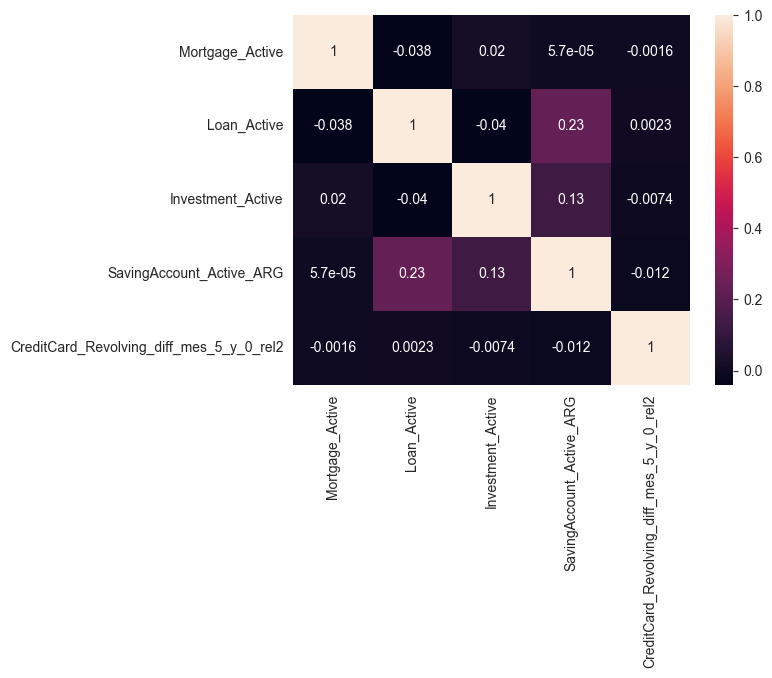

In [690]:
sns.heatmap(corr, annot=True)

In [691]:
corr = ABT.corr()
corr.head(10)

,client_id,TGT_x,CreditCard_Premium,CreditCard_Active,Loan_Active,Mortgage_Active,SavingAccount_Active_ARG_Salary,SavingAccount_Active_ARG,SavingAccount_Active_DOLLAR,DebitCard_Active,...,CreditCard_utilization_diff_mes_5_y_0_abs,CreditCard_utilization_diff_mes_5_y_0_rel,CreditCard_utilization_diff_mes_5_y_0_rel2,CreditCard_spend_installments_ratio_diff_mes_5_y_0_abs,CreditCard_spend_installments_ratio_diff_mes_5_y_0_rel,CreditCard_spend_installments_ratio_diff_mes_5_y_0_rel2,CreditCard_auto_debit_ratio_diff_mes_5_y_0_abs,CreditCard_auto_debit_ratio_diff_mes_5_y_0_rel,CreditCard_auto_debit_ratio_diff_mes_5_y_0_rel2,CreditCard_utilization_diff_mes_5_y_0_abs_bin
client_id,1.000000,-0.048465,0.044398,-0.148117,0.008420,-0.125800,0.076811,0.179497,0.045123,0.149141,...,-0.008965,0.004414,-0.004414,-0.004900,-0.007639,0.007639,-0.004747,-0.006158,0.006158,0.110650
TGT_x,-0.048465,1.000000,0.079683,0.374440,0.135903,-0.007481,0.213590,0.045188,0.078836,0.091495,...,0.004693,0.005303,-0.005303,0.006237,0.005341,-0.005341,-0.013095,-0.039011,0.039011,-0.187704
CreditCard_Premium,0.044398,0.079683,1.000000,0.254667,-0.007414,-0.015391,-0.059728,-0.135524,-0.071107,-0.099862,...,0.018635,0.001244,-0.001244,-0.003400,0.009572,-0.009572,0.001095,0.046150,-0.046150,-0.152123
CreditCard_Active,-0.148117,0.374440,0.254667,1.000000,0.038196,-0.052002,-0.054037,-0.401302,-0.159098,-0.285630,...,0.044074,0.008817,-0.008817,-0.017936,-0.011059,0.011059,-0.028299,0.003286,-0.003286,-0.557429
Loan_Active,0.008420,0.135903,-0.007414,0.038196,1.000000,-0.037892,0.037689,0.231452,0.162303,0.223872,...,-0.014094,-0.002908,0.002908,0.008256,-0.001167,0.001167,0.002501,-0.014895,0.014895,-0.069377
Mortgage_Active,-0.125800,-0.007481,-0.015391,-0.052002,-0.037892,1.000000,0.026638,0.000057,0.022298,0.002179,...,-0.007858,-0.002920,0.002920,0.003810,0.003754,-0.003754,0.001667,-0.003904,0.003904,0.024648
SavingAccount_Active_ARG_Salary,0.076811,0.213590,-0.059728,-0.054037,0.037689,0.026638,1.000000,0.202671,0.144602,0.218246,...,-0.003318,-0.006045,0.006045,0.003126,0.001235,-0.001235,0.002605,0.037385,-0.037385,0.043065
SavingAccount_Active_ARG,0.179497,0.045188,-0.135524,-0.401302,0.231452,0.000057,0.202671,1.000000,0.572907,0.843082,...,-0.051973,-0.008050,0.008050,0.013561,0.012274,-0.012274,0.000505,0.005534,-0.005534,0.173833
SavingAccount_Active_DOLLAR,0.045123,0.078836,-0.071107,-0.159098,0.162303,0.022298,0.144602,0.572907,1.000000,0.538779,...,-0.035881,-0.003369,0.003369,0.015593,0.007339,-0.007339,-0.000928,0.010340,-0.010340,0.024122
DebitCard_Active,0.149141,0.091495,-0.099862,-0.285630,0.223872,0.002179,0.218246,0.843082,0.538779,1.000000,...,-0.049157,-0.007839,0.007839,0.013048,0.012256,-0.012256,0.000118,0.006594,-0.006594,0.106480


In [692]:
[x for x in ABT.columns if x.find('T') >= 0]

['TGT_x',
 'TGT_y',
 'SavingAccount_Salary_Payment_Transactions_sum',
 'SavingAccount_Salary_Payment_Transactions_max',
 'SavingAccount_Salary_Payment_Transactions_min',
 'SavingAccount_Salary_Payment_Transactions_mean',
 'SavingAccount_Salary_Payment_Transactions_median',
 'SavingAccount_Salary_Payment_Transactions_nunique',
 'SavingAccount_Salary_Payment_Transactions_std',
 'SavingAccount_Salary_Payment_Transactions_var',
 'SavingAccount_Salary_Payment_Transactions_ptp',
 'SavingAccount_Transfer_In_Transactions_sum',
 'SavingAccount_Transfer_In_Transactions_max',
 'SavingAccount_Transfer_In_Transactions_min',
 'SavingAccount_Transfer_In_Transactions_mean',
 'SavingAccount_Transfer_In_Transactions_median',
 'SavingAccount_Transfer_In_Transactions_nunique',
 'SavingAccount_Transfer_In_Transactions_std',
 'SavingAccount_Transfer_In_Transactions_var',
 'SavingAccount_Transfer_In_Transactions_ptp',
 'SavingAccount_ATM_Extraction_Transactions_sum',
 'SavingAccount_ATM_Extraction_Transactio

In [693]:
data_TGT.columns

Index(['client_id', 'TGT'], dtype='object')

In [694]:
# Calcular matriz de correlación absoluta
corr_matrix = ABT.drop(['client_id', 'TGT_x'], axis=1, errors='ignore').corr().abs()

# Seleccionar triángulo superior
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Encontrar columnas con correlación > 0.85
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

# 🔒 Evitar que se elimine 'CreditCard_Product_tgt'
protected_cols = ['CreditCard_Product_tgt']
to_drop = [col for col in to_drop if col not in protected_cols]

print(f"Columnas con alta correlación: {len(to_drop)}")
print(to_drop[:10])  # muestra las primeras 10

# Eliminar las columnas
ABT.drop(columns=to_drop, inplace=True, errors='ignore')

print("Nuevo shape:", ABT.shape)


Columnas con alta correlación: 259
['SavingAccount_Balance_FirstDate_max', 'SavingAccount_Balance_FirstDate_mean', 'SavingAccount_Balance_FirstDate_median', 'SavingAccount_Balance_FirstDate_std', 'SavingAccount_Balance_FirstDate_ptp', 'SavingAccount_Balance_LastDate_sum', 'SavingAccount_Balance_LastDate_max', 'SavingAccount_Balance_LastDate_min', 'SavingAccount_Balance_LastDate_mean', 'SavingAccount_Balance_LastDate_median']
Nuevo shape: (23191, 137)


In [695]:
to_drop

['SavingAccount_Balance_FirstDate_max',
 'SavingAccount_Balance_FirstDate_mean',
 'SavingAccount_Balance_FirstDate_median',
 'SavingAccount_Balance_FirstDate_std',
 'SavingAccount_Balance_FirstDate_ptp',
 'SavingAccount_Balance_LastDate_sum',
 'SavingAccount_Balance_LastDate_max',
 'SavingAccount_Balance_LastDate_min',
 'SavingAccount_Balance_LastDate_mean',
 'SavingAccount_Balance_LastDate_median',
 'SavingAccount_Balance_LastDate_nunique',
 'SavingAccount_Balance_LastDate_std',
 'SavingAccount_Balance_LastDate_var',
 'SavingAccount_Balance_LastDate_ptp',
 'SavingAccount_Balance_Average_max',
 'SavingAccount_Balance_Average_min',
 'SavingAccount_Balance_Average_mean',
 'SavingAccount_Balance_Average_median',
 'SavingAccount_Balance_Average_nunique',
 'SavingAccount_Balance_Average_std',
 'SavingAccount_Balance_Average_var',
 'SavingAccount_Balance_Average_ptp',
 'SavingAccount_Days_with_use_max',
 'SavingAccount_Days_with_use_min',
 'SavingAccount_Days_with_use_mean',
 'SavingAccount_

In [696]:
ABT.head(10)

,client_id,TGT_x,CreditCard_Premium,CreditCard_Active,Loan_Active,Mortgage_Active,SavingAccount_Active_ARG_Salary,SavingAccount_Active_ARG,SavingAccount_Active_DOLLAR,DebitCard_Active,...,CreditCard_Payment_External_diff_mes_5_y_0_abs,CreditCard_Payment_Cash_diff_mes_5_y_0_abs,CreditCard_Payment_Web_diff_mes_5_y_0_abs,CreditCard_Payment_ATM_diff_mes_5_y_0_abs,CreditCard_Payment_TAS_diff_mes_5_y_0_abs,CreditCard_utilization_diff_mes_5_y_0_abs,CreditCard_spend_installments_ratio_diff_mes_5_y_0_abs,CreditCard_auto_debit_ratio_diff_mes_5_y_0_abs,CreditCard_auto_debit_ratio_diff_mes_5_y_0_rel,CreditCard_utilization_diff_mes_5_y_0_abs_bin
0,5856970,1.0,0,1,0,0,0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.078784,-0.145541,-0.000056,0.590410,3
1,6371753,0.0,0,0,0,0,0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,4
2,5928737,0.0,0,0,0,0,0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,4
3,475064,0.0,0,1,0,0,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,-0.006598,0.052916,0.000093,1.298107,2
4,3615172,0.0,0,0,0,0,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,4
5,6412264,0.0,0,0,0,0,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,4
6,6318899,0.0,0,0,0,0,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,4
7,7272795,1.0,0,1,1,0,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,4
8,4976363,0.0,0,0,0,0,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,4
9,5775560,0.0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,-0.009489,NaN,0.000000,NaN,2


# PCA

### Define Standard scaler and fit to the data_scaled

In [697]:
num_cols = ABT.select_dtypes(include=['float64','int64','Float64','Int64']).columns
cols_to_scale = [c for c in num_cols if c not in ['client_id','TGT','TGT_x','TGT_y']]

X = ABT[cols_to_scale]

bad_inf = X.columns[np.isinf(X.to_numpy()).any(axis=0)].tolist()
bad_nan = X.columns[X.isna().any(axis=0)].tolist()
print("Con inf:", bad_inf[:10], "… total:", len(bad_inf))
print("Con NaN:", bad_nan[:10], "… total:", len(bad_nan))

Con inf: ['SavingAccount_Balance_FirstDate_diff_mes_5_y_0_rel', 'SavingAccount_Balance_LastDate_diff_mes_5_y_0_rel', 'SavingAccount_Balance_Average_diff_mes_5_y_0_rel', 'SavingAccount_Days_with_use_diff_mes_5_y_0_rel', 'SavingAccount_Days_with_Credits_diff_mes_5_y_0_rel', 'SavingAccount_Days_with_Debits_diff_mes_5_y_0_rel', 'SavingAccount_Transfer_In_Transactions_diff_mes_5_y_0_rel', 'SavingAccount_ATM_Extraction_Transactions_diff_mes_5_y_0_rel', 'SavingAccount_Service_Payment_Transactions_diff_mes_5_y_0_rel', 'SavingAccount_CreditCard_Payment_Transactions_diff_mes_5_y_0_rel'] … total: 29
Con NaN: ['CreditCard_Product_tgt', 'SavingAccount_use_ratio_max', 'SavingAccount_use_ratio_min', 'SavingAccount_use_ratio_mean', 'SavingAccount_use_ratio_median', 'SavingAccount_use_ratio_std', 'SavingAccount_Balance_FirstDate_diff_mes_5_y_0_rel', 'SavingAccount_Balance_LastDate_diff_mes_5_y_0_rel', 'SavingAccount_Balance_Average_diff_mes_5_y_0_rel', 'SavingAccount_Days_with_use_diff_mes_5_y_0_rel'] 

In [698]:
X = X.replace([np.inf, -np.inf], np.nan)


X = X.apply(lambda s: s.fillna(s.median())).astype('float64')


lower = X.quantile(0.001)
upper = X.quantile(0.999)
X = X.clip(lower=lower, upper=upper, axis=1)

In [699]:
scaler = StandardScaler()

data_scaled = scaler.fit_transform(X)
ABT_scaled = pd.DataFrame(data_scaled, columns=X.columns, index=ABT.index)

In [700]:
ABT_scaled.head(10)

,Client_Age_grp_tgt,Region_tgt,CreditCard_Product_tgt,SavingAccount_Balance_FirstDate_sum,SavingAccount_Balance_FirstDate_min,SavingAccount_Balance_FirstDate_nunique,SavingAccount_Balance_FirstDate_var,SavingAccount_Balance_Average_sum,SavingAccount_Days_with_use_sum,SavingAccount_Days_with_use_nunique,...,CreditCard_Payment_External_diff_mes_5_y_0_abs,CreditCard_Payment_Cash_diff_mes_5_y_0_abs,CreditCard_Payment_Web_diff_mes_5_y_0_abs,CreditCard_Payment_ATM_diff_mes_5_y_0_abs,CreditCard_Payment_TAS_diff_mes_5_y_0_abs,CreditCard_utilization_diff_mes_5_y_0_abs,CreditCard_spend_installments_ratio_diff_mes_5_y_0_abs,CreditCard_auto_debit_ratio_diff_mes_5_y_0_abs,CreditCard_auto_debit_ratio_diff_mes_5_y_0_rel,CreditCard_utilization_diff_mes_5_y_0_abs_bin
0,2.771773,1.521506,0.440188,-0.252552,-0.186258,1.198975,-0.080085,-0.135684,0.961579,1.38800,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,0.893070,-0.515485,-0.138488,-0.325012,0.221044
1,0.091215,-1.698636,-1.377035,-0.206547,-0.179020,1.198975,-0.079259,-0.345334,0.373024,1.38800,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
2,-0.645939,0.090332,-1.377035,-0.257122,-0.186258,-0.967401,-0.080089,-0.438574,-0.750581,-0.86089,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
3,2.771773,0.090332,0.440188,-0.094643,-0.133371,1.198975,-0.077381,-0.048621,0.212509,-0.86089,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.262819,0.252622,0.077194,0.583703,-0.617122
4,-0.645939,-1.698636,-1.377035,-0.257098,-0.186207,-0.967401,-0.080089,-0.438504,-0.750581,-0.86089,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
5,-0.645939,0.090332,-1.377035,-0.160273,-0.122425,1.198975,-0.079852,-0.151293,0.426529,-0.11126,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
6,0.091215,0.090332,-1.377035,0.209721,-0.186258,1.198975,-0.052403,-0.297967,0.854569,1.38800,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
7,-0.645939,0.090332,0.440188,-0.253463,-0.181554,1.198975,-0.080088,-0.318973,0.266014,0.63837,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
8,-0.645939,0.090332,-1.377035,1.243640,0.360581,1.198975,0.571636,2.249130,0.212509,1.38800,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
9,-0.645939,-1.698636,0.878828,-0.257122,-0.186258,-0.967401,-0.080089,-0.438574,-0.750581,-0.86089,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.301953,0.047816,-0.056911,-0.073551,-0.617122


In [701]:
print(len(ABT), len(data_scaled))

23191 23191


In [702]:
ABT = pd.concat(
    [
        ABT[['client_id']].reset_index(drop=True),
        ABT_scaled.reset_index(drop=True)
    ],
    axis=1
)

In [703]:
ABT.head(10)

,client_id,Client_Age_grp_tgt,Region_tgt,CreditCard_Product_tgt,SavingAccount_Balance_FirstDate_sum,SavingAccount_Balance_FirstDate_min,SavingAccount_Balance_FirstDate_nunique,SavingAccount_Balance_FirstDate_var,SavingAccount_Balance_Average_sum,SavingAccount_Days_with_use_sum,...,CreditCard_Payment_External_diff_mes_5_y_0_abs,CreditCard_Payment_Cash_diff_mes_5_y_0_abs,CreditCard_Payment_Web_diff_mes_5_y_0_abs,CreditCard_Payment_ATM_diff_mes_5_y_0_abs,CreditCard_Payment_TAS_diff_mes_5_y_0_abs,CreditCard_utilization_diff_mes_5_y_0_abs,CreditCard_spend_installments_ratio_diff_mes_5_y_0_abs,CreditCard_auto_debit_ratio_diff_mes_5_y_0_abs,CreditCard_auto_debit_ratio_diff_mes_5_y_0_rel,CreditCard_utilization_diff_mes_5_y_0_abs_bin
0,5856970,2.771773,1.521506,0.440188,-0.252552,-0.186258,1.198975,-0.080085,-0.135684,0.961579,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,0.893070,-0.515485,-0.138488,-0.325012,0.221044
1,6371753,0.091215,-1.698636,-1.377035,-0.206547,-0.179020,1.198975,-0.079259,-0.345334,0.373024,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
2,5928737,-0.645939,0.090332,-1.377035,-0.257122,-0.186258,-0.967401,-0.080089,-0.438574,-0.750581,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
3,475064,2.771773,0.090332,0.440188,-0.094643,-0.133371,1.198975,-0.077381,-0.048621,0.212509,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.262819,0.252622,0.077194,0.583703,-0.617122
4,3615172,-0.645939,-1.698636,-1.377035,-0.257098,-0.186207,-0.967401,-0.080089,-0.438504,-0.750581,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
5,6412264,-0.645939,0.090332,-1.377035,-0.160273,-0.122425,1.198975,-0.079852,-0.151293,0.426529,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
6,6318899,0.091215,0.090332,-1.377035,0.209721,-0.186258,1.198975,-0.052403,-0.297967,0.854569,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
7,7272795,-0.645939,0.090332,0.440188,-0.253463,-0.181554,1.198975,-0.080088,-0.318973,0.266014,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
8,4976363,-0.645939,0.090332,-1.377035,1.243640,0.360581,1.198975,0.571636,2.249130,0.212509,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
9,5775560,-0.645939,-1.698636,0.878828,-0.257122,-0.186258,-0.967401,-0.080089,-0.438574,-0.750581,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.301953,0.047816,-0.056911,-0.073551,-0.617122


### Definir PCA con n componentes y random_state =1 y ajustarlo a los datos escalados.

In [704]:
n = data_scaled.shape[1]

pca1 = PCA(n_components=n, random_state=1)
data_pca = pd.DataFrame(pca1.fit_transform(data_scaled))

exp_var1 = pca1.explained_variance_ratio_

In [705]:
n

124

Text(0, 0.5, 'Cumulative Explained Variance')

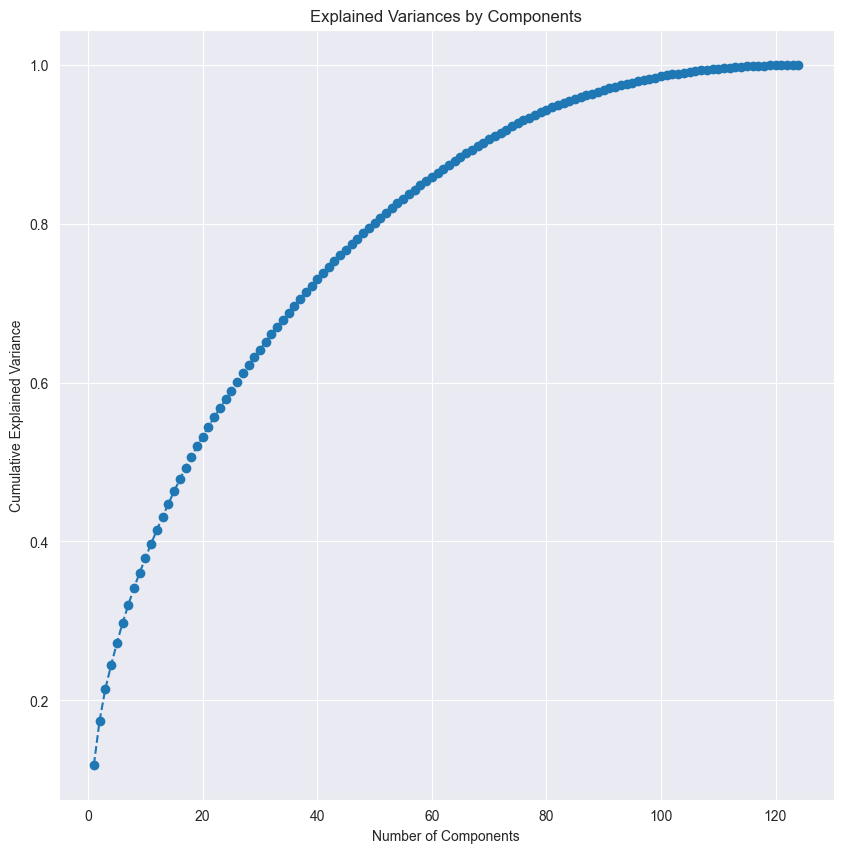

In [706]:
plt.figure(figsize = (10,10))
plt.plot(range(1,n+1), pca1.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title("Explained Variances by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")

### Análisis de Varianza Explicada

Determinación del número óptimo de componentes principales que explican un porcentaje significativo de la varianza total.

Identificación del número mínimo de componentes principales necesarios para explicar al menos 80% de la varianza.

In [707]:
# find the least number of components that can explain more than 80% variance
sum = 0
for ix, i in enumerate(exp_var1):
  sum = sum + i
  if(sum>0.80):
    print("Number of PCs that explain at least 80% variance: ", ix+1)
    break

Number of PCs that explain at least 80% variance:  50


In [708]:
# find the least number of components that can explain more than 80% variance
sum = 0
for ix, i in enumerate(exp_var1):
  sum = sum + i
  if(sum>0.70):
    print("Number of PCs that explain at least 70% variance: ", ix+1)
    break

Number of PCs that explain at least 70% variance:  37


In [709]:
cols_pca = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']

feat_cols = [f'feat_{i}' for i in range(data_scaled.shape[1])]  # 16 genéricos
data_scaled = pd.DataFrame(data_scaled, columns=feat_cols)

pc1 = pd.DataFrame(
    np.round(pca1.components_.T[:, 0:6], 2),
    index=data_scaled.columns,
    columns=cols_pca
)


In [710]:
pca1.components_

array([[-2.33818273e-02, -3.23742002e-04,  2.08737194e-02, ...,
         1.39279913e-02,  1.68708144e-02, -2.33742488e-02],
       [ 4.28313140e-03, -7.38250665e-03,  5.52041275e-04, ...,
         2.32527667e-02, -2.94881020e-03,  1.53248899e-02],
       [ 7.32761060e-03,  8.53512163e-03, -3.76304369e-02, ...,
        -2.67810181e-02, -3.96653093e-02,  4.73041023e-02],
       ...,
       [-6.07561038e-04, -7.85302219e-04, -3.05646992e-03, ...,
        -3.73119295e-03,  3.56008617e-03, -2.04178931e-03],
       [-9.29375669e-04, -1.36254016e-03, -3.15305727e-04, ...,
        -4.73520607e-04, -4.80992819e-05,  5.93619574e-04],
       [-2.96353476e-17, -4.94385898e-17,  7.62291136e-16, ...,
        -1.94289029e-16,  1.11022302e-16,  1.66533454e-16]],
      shape=(124, 124))

### Interpretación de Componentes Principales

Análisis de los coeficientes de los componentes principales para entender qué características originales contribuyen más a cada componente.

In [711]:
def color_high(val):
    if val <= -0.25: 
        return 'background: pink'
    elif val >= 0.25:
        return 'background: skyblue'

pc1.style.applymap(color_high)

C:\Users\carlo\AppData\Local\Temp\ipykernel_29192\1677305788.py:7: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  pc1.style.applymap(color_high)


,PC1,PC2,PC3,PC4,PC5,PC6
feat_0,-0.020000,0.000000,0.010000,0.030000,-0.020000,0.090000
feat_1,-0.000000,-0.010000,0.010000,0.030000,-0.010000,0.040000
feat_2,0.020000,0.000000,-0.040000,0.110000,-0.010000,0.030000
feat_3,0.150000,-0.050000,0.130000,0.020000,-0.020000,0.130000
feat_4,0.120000,-0.040000,0.150000,0.020000,-0.010000,0.070000
feat_5,0.150000,-0.040000,-0.090000,-0.080000,0.080000,-0.230000
feat_6,0.060000,-0.030000,0.050000,0.020000,-0.040000,0.170000
feat_7,0.190000,-0.040000,0.100000,0.000000,-0.000000,0.020000
feat_8,0.220000,-0.040000,0.000000,-0.050000,0.060000,-0.180000
feat_9,0.110000,-0.010000,-0.130000,-0.080000,0.120000,-0.200000


Luego de este analisis, hay que borrar de la ABT las 29 columnas y quedarse con los 8 PCA que quiero....

## Selección de Características

Identificación de las características más importantes para el modelo mediante análisis de importancia de características.

In [712]:
ABT.head(10)

,client_id,Client_Age_grp_tgt,Region_tgt,CreditCard_Product_tgt,SavingAccount_Balance_FirstDate_sum,SavingAccount_Balance_FirstDate_min,SavingAccount_Balance_FirstDate_nunique,SavingAccount_Balance_FirstDate_var,SavingAccount_Balance_Average_sum,SavingAccount_Days_with_use_sum,...,CreditCard_Payment_External_diff_mes_5_y_0_abs,CreditCard_Payment_Cash_diff_mes_5_y_0_abs,CreditCard_Payment_Web_diff_mes_5_y_0_abs,CreditCard_Payment_ATM_diff_mes_5_y_0_abs,CreditCard_Payment_TAS_diff_mes_5_y_0_abs,CreditCard_utilization_diff_mes_5_y_0_abs,CreditCard_spend_installments_ratio_diff_mes_5_y_0_abs,CreditCard_auto_debit_ratio_diff_mes_5_y_0_abs,CreditCard_auto_debit_ratio_diff_mes_5_y_0_rel,CreditCard_utilization_diff_mes_5_y_0_abs_bin
0,5856970,2.771773,1.521506,0.440188,-0.252552,-0.186258,1.198975,-0.080085,-0.135684,0.961579,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,0.893070,-0.515485,-0.138488,-0.325012,0.221044
1,6371753,0.091215,-1.698636,-1.377035,-0.206547,-0.179020,1.198975,-0.079259,-0.345334,0.373024,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
2,5928737,-0.645939,0.090332,-1.377035,-0.257122,-0.186258,-0.967401,-0.080089,-0.438574,-0.750581,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
3,475064,2.771773,0.090332,0.440188,-0.094643,-0.133371,1.198975,-0.077381,-0.048621,0.212509,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.262819,0.252622,0.077194,0.583703,-0.617122
4,3615172,-0.645939,-1.698636,-1.377035,-0.257098,-0.186207,-0.967401,-0.080089,-0.438504,-0.750581,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
5,6412264,-0.645939,0.090332,-1.377035,-0.160273,-0.122425,1.198975,-0.079852,-0.151293,0.426529,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
6,6318899,0.091215,0.090332,-1.377035,0.209721,-0.186258,1.198975,-0.052403,-0.297967,0.854569,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
7,7272795,-0.645939,0.090332,0.440188,-0.253463,-0.181554,1.198975,-0.080088,-0.318973,0.266014,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
8,4976363,-0.645939,0.090332,-1.377035,1.243640,0.360581,1.198975,0.571636,2.249130,0.212509,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
9,5775560,-0.645939,-1.698636,0.878828,-0.257122,-0.186258,-0.967401,-0.080089,-0.438574,-0.750581,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.301953,0.047816,-0.056911,-0.073551,-0.617122


In [713]:
ABT['TGT'] = ABT_backup['TGT_x']


ABT['idx'] = ABT['client_id']

In [714]:
b = [x for x in ABT.columns if x.find('Active') >= 0]
b += [x for x in ABT.columns if x.endswith('_rel') ]

ABT.drop(b, axis=1, inplace= True)

In [715]:
ABT.columns

Index(['client_id', 'Client_Age_grp_tgt', 'Region_tgt',
       'CreditCard_Product_tgt', 'SavingAccount_Balance_FirstDate_sum',
       'SavingAccount_Balance_FirstDate_min',
       'SavingAccount_Balance_FirstDate_nunique',
       'SavingAccount_Balance_FirstDate_var',
       'SavingAccount_Balance_Average_sum', 'SavingAccount_Days_with_use_sum',
       'SavingAccount_Days_with_use_nunique',
       'SavingAccount_Salary_Payment_Transactions_sum',
       'SavingAccount_Transfer_In_Transactions_sum',
       'SavingAccount_Transfer_In_Transactions_nunique',
       'SavingAccount_Transfer_In_Transactions_var',
       'SavingAccount_ATM_Extraction_Transactions_sum',
       'SavingAccount_Service_Payment_Transactions_sum',
       'SavingAccount_Service_Payment_Transactions_var',
       'SavingAccount_CreditCard_Payment_Transactions_sum',
       'SavingAccount_CreditCard_Payment_Transactions_var',
       'SavingAccount_Transfer_Out_Transactions_sum',
       'SavingAccount_Transfer_Out_Transac

In [716]:
cols = ['client_id']
ABT.drop(cols, axis=1, inplace= True)

### Estandarización Final

Los datos ya están estandarizados desde el paso anterior de PCA. Se procede directamente con el modelado.

In [717]:
ABT_Model = ABT.copy()
ABT_Model.head(5)

,Client_Age_grp_tgt,Region_tgt,CreditCard_Product_tgt,SavingAccount_Balance_FirstDate_sum,SavingAccount_Balance_FirstDate_min,SavingAccount_Balance_FirstDate_nunique,SavingAccount_Balance_FirstDate_var,SavingAccount_Balance_Average_sum,SavingAccount_Days_with_use_sum,SavingAccount_Days_with_use_nunique,...,CreditCard_Payment_Cash_diff_mes_5_y_0_abs,CreditCard_Payment_Web_diff_mes_5_y_0_abs,CreditCard_Payment_ATM_diff_mes_5_y_0_abs,CreditCard_Payment_TAS_diff_mes_5_y_0_abs,CreditCard_utilization_diff_mes_5_y_0_abs,CreditCard_spend_installments_ratio_diff_mes_5_y_0_abs,CreditCard_auto_debit_ratio_diff_mes_5_y_0_abs,CreditCard_utilization_diff_mes_5_y_0_abs_bin,TGT,idx
0,2.771773,1.521506,0.440188,-0.252552,-0.186258,1.198975,-0.080085,-0.135684,0.961579,1.38800,...,-0.041926,-0.042772,-0.027974,-0.042541,0.893070,-0.515485,-0.138488,0.221044,1.0,5856970
1,0.091215,-1.698636,-1.377035,-0.206547,-0.179020,1.198975,-0.079259,-0.345334,0.373024,1.38800,...,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,1.059209,0.0,6371753
2,-0.645939,0.090332,-1.377035,-0.257122,-0.186258,-0.967401,-0.080089,-0.438574,-0.750581,-0.86089,...,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,1.059209,0.0,5928737
3,2.771773,0.090332,0.440188,-0.094643,-0.133371,1.198975,-0.077381,-0.048621,0.212509,-0.86089,...,-0.041926,-0.042772,-0.027974,-0.042541,-0.262819,0.252622,0.077194,-0.617122,0.0,475064
4,-0.645939,-1.698636,-1.377035,-0.257098,-0.186207,-0.967401,-0.080089,-0.438504,-0.750581,-0.86089,...,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,1.059209,0.0,3615172


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[16]	valid_0's auc: 0.809887	valid_0's binary_logloss: 0.480925
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[16]	valid_0's auc: 0.812541	valid_0's binary_logloss: 0.47925
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[16]	valid_0's auc: 0.809116	valid_0's binary_logloss: 0.48057
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[17]	valid_0's auc: 0.807126	valid_0's binary_logloss: 0.482372
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[17]	valid_0's auc: 0.808984	valid_0's binary_logloss: 0.480403
Training until validation scores don't improve for 100 rounds
Did not

<Axes: >

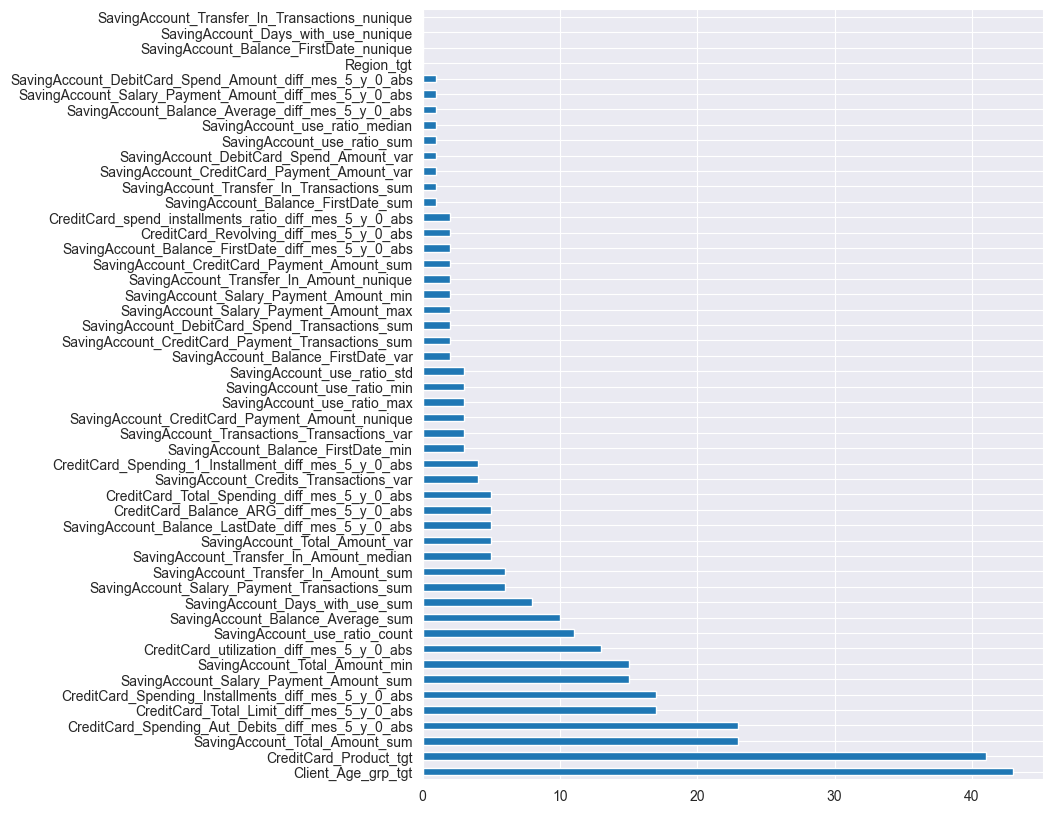

In [718]:
target_column = 'TGT'
numerical_cols = [x for x in ABT_Model.columns if (x != 'idx') & (x != 'TGT') ]


fit_params = {
    "eval_metric": "auc",
    "eval_set": [(ABT_Model[numerical_cols], ABT_Model[target_column])],
    "callbacks": [
        lgb.early_stopping(stopping_rounds=100, verbose=True),
        lgb.log_evaluation(period=100)
    ]
}

param_test = {
    'num_leaves': np.arange(15, 20, 1),
    'min_data_in_leaf': np.arange(1000, 3000, 100),
    'subsample': sp_uniform(loc=0.2, scale=0.8),
    'max_depth': np.arange(6, 10, 1),
    'n_estimators': np.arange(15, 20, 1)
}

n_HP_points_to_test = 100

# ========= Clasificador (parámetros válidos en sklearn wrapper) =========
clf = lgb.LGBMClassifier(
    random_state=314,
    n_jobs=4,
    verbosity=-1
)

gs = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_test,
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    verbose=1
)

# IMPORTANTE: los datos deben ser NUMÉRICOS y finitos (ya los limpiaste arriba)
gs.fit(ABT_Model[numerical_cols], ABT_Model[target_column], **fit_params)

feat_imp = pd.Series(gs.best_estimator_.feature_importances_, index=ABT_Model[numerical_cols].columns)
feat_imp.nlargest(50).plot(kind='barh', figsize=(8,10))


In [719]:
a = pd.DataFrame(feat_imp.nlargest(50))
a

,0
Client_Age_grp_tgt,43
CreditCard_Product_tgt,41
SavingAccount_Total_Amount_sum,23
CreditCard_Spending_Aut_Debits_diff_mes_5_y_0_abs,23
CreditCard_Total_Limit_diff_mes_5_y_0_abs,17
CreditCard_Spending_Installments_diff_mes_5_y_0_abs,17
SavingAccount_Salary_Payment_Amount_sum,15
SavingAccount_Total_Amount_min,15
CreditCard_utilization_diff_mes_5_y_0_abs,13
SavingAccount_use_ratio_count,11


## Bivariados

In [720]:
#ABT['idx'] = ABT['client_id']
# ABT['TGT'] = ABT['TGT_x']
ABT

,Client_Age_grp_tgt,Region_tgt,CreditCard_Product_tgt,SavingAccount_Balance_FirstDate_sum,SavingAccount_Balance_FirstDate_min,SavingAccount_Balance_FirstDate_nunique,SavingAccount_Balance_FirstDate_var,SavingAccount_Balance_Average_sum,SavingAccount_Days_with_use_sum,SavingAccount_Days_with_use_nunique,...,CreditCard_Payment_Cash_diff_mes_5_y_0_abs,CreditCard_Payment_Web_diff_mes_5_y_0_abs,CreditCard_Payment_ATM_diff_mes_5_y_0_abs,CreditCard_Payment_TAS_diff_mes_5_y_0_abs,CreditCard_utilization_diff_mes_5_y_0_abs,CreditCard_spend_installments_ratio_diff_mes_5_y_0_abs,CreditCard_auto_debit_ratio_diff_mes_5_y_0_abs,CreditCard_utilization_diff_mes_5_y_0_abs_bin,TGT,idx
0,2.771773,1.521506,0.440188,-0.252552,-0.186258,1.198975,-0.080085,-0.135684,0.961579,1.38800,...,-0.041926,-0.042772,-0.027974,-0.042541,0.893070,-0.515485,-0.138488,0.221044,1.0,5856970
1,0.091215,-1.698636,-1.377035,-0.206547,-0.179020,1.198975,-0.079259,-0.345334,0.373024,1.38800,...,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,1.059209,0.0,6371753
2,-0.645939,0.090332,-1.377035,-0.257122,-0.186258,-0.967401,-0.080089,-0.438574,-0.750581,-0.86089,...,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,1.059209,0.0,5928737
3,2.771773,0.090332,0.440188,-0.094643,-0.133371,1.198975,-0.077381,-0.048621,0.212509,-0.86089,...,-0.041926,-0.042772,-0.027974,-0.042541,-0.262819,0.252622,0.077194,-0.617122,0.0,475064
4,-0.645939,-1.698636,-1.377035,-0.257098,-0.186207,-0.967401,-0.080089,-0.438504,-0.750581,-0.86089,...,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,1.059209,0.0,3615172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23186,-0.645939,0.090332,0.440188,-0.257122,-0.186258,-0.967401,-0.080089,-0.438574,-0.750581,-0.86089,...,-0.041926,3.177797,-0.027974,-0.042541,-1.838240,3.125787,-0.056911,-0.617122,0.0,4221845
23187,-0.645939,1.521506,0.878828,-0.257122,-0.186258,-0.967401,-0.080089,-0.438574,-0.750581,-0.86089,...,-0.041926,-0.042772,-0.027974,-0.042541,0.245788,0.047816,-0.056911,-0.617122,0.0,1988103
23188,-0.645939,-1.698636,-1.377035,-0.161449,0.014668,1.198975,-0.080089,-0.146594,0.105499,-0.11126,...,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,1.059209,0.0,4908119
23189,-0.645939,0.090332,0.440188,-0.257122,-0.186258,-0.967401,-0.080089,-0.438574,-0.750581,-0.86089,...,-0.041926,-0.042772,-0.027974,6.447981,-0.624690,0.047816,-0.056911,-0.617122,1.0,3028372


## Transformo con bivariados

In [721]:
ABT['CreditCard_utilization_diff_mes_5_y_0_abs'] = np.where(ABT['CreditCard_utilization_diff_mes_5_y_0_abs'] == 0, 0 ,
                                               np.where(ABT['CreditCard_utilization_diff_mes_5_y_0_abs'] == 42,  42,

                                               100
                                               )

                                               )


ABT['CreditCard_utilization_diff_mes_5_y_0_abs'].value_counts()

CreditCard_utilization_diff_mes_5_y_0_abs
100    23191
Name: count, dtype: int64

## Modelado con LightGBM

Entrenamiento del modelo de clasificación utilizando LightGBM con optimización de hiperparámetros mediante búsqueda aleatoria.

In [722]:
ABT = ABT.fillna(0)

In [723]:
X_train, X_test = train_test_split(ABT, test_size=0.3, random_state=42, stratify=ABT['TGT']);

In [724]:
type(X_train)

pandas.core.frame.DataFrame

In [725]:
ABT.shape

(23191, 97)

In [726]:
X_train.shape

(16233, 97)

In [727]:
 np.arange(6, 20, 1),

(array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),)

In [728]:
 np.arange(6, 20, 2),

(array([ 6,  8, 10, 12, 14, 16, 18]),)

In [729]:
ABT.columns

Index(['Client_Age_grp_tgt', 'Region_tgt', 'CreditCard_Product_tgt',
       'SavingAccount_Balance_FirstDate_sum',
       'SavingAccount_Balance_FirstDate_min',
       'SavingAccount_Balance_FirstDate_nunique',
       'SavingAccount_Balance_FirstDate_var',
       'SavingAccount_Balance_Average_sum', 'SavingAccount_Days_with_use_sum',
       'SavingAccount_Days_with_use_nunique',
       'SavingAccount_Salary_Payment_Transactions_sum',
       'SavingAccount_Transfer_In_Transactions_sum',
       'SavingAccount_Transfer_In_Transactions_nunique',
       'SavingAccount_Transfer_In_Transactions_var',
       'SavingAccount_ATM_Extraction_Transactions_sum',
       'SavingAccount_Service_Payment_Transactions_sum',
       'SavingAccount_Service_Payment_Transactions_var',
       'SavingAccount_CreditCard_Payment_Transactions_sum',
       'SavingAccount_CreditCard_Payment_Transactions_var',
       'SavingAccount_Transfer_Out_Transactions_sum',
       'SavingAccount_Transfer_Out_Transactions_nunique

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.831176	valid_0's binary_logloss: 0.445521
Did not meet early stopping. Best iteration is:
[71]	valid_0's auc: 0.832339	valid_0's binary_logloss: 0.44387
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.831651	valid_0's binary_logloss: 0.443582
Did not meet early stopping. Best iteration is:
[64]	valid_0's auc: 0.832419	valid_0's binary_logloss: 0.442845
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.830251	valid_0's binary_logloss: 0.446442
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.830837	valid_0's binary_logloss: 0.445682
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.820096	valid_0's binary_logloss: 0.46013
[200]	valid_0's auc: 0.823715	valid_0's binary_logloss: 0.45303
[300]	valid_0's auc: 0.824978	va

<Axes: >

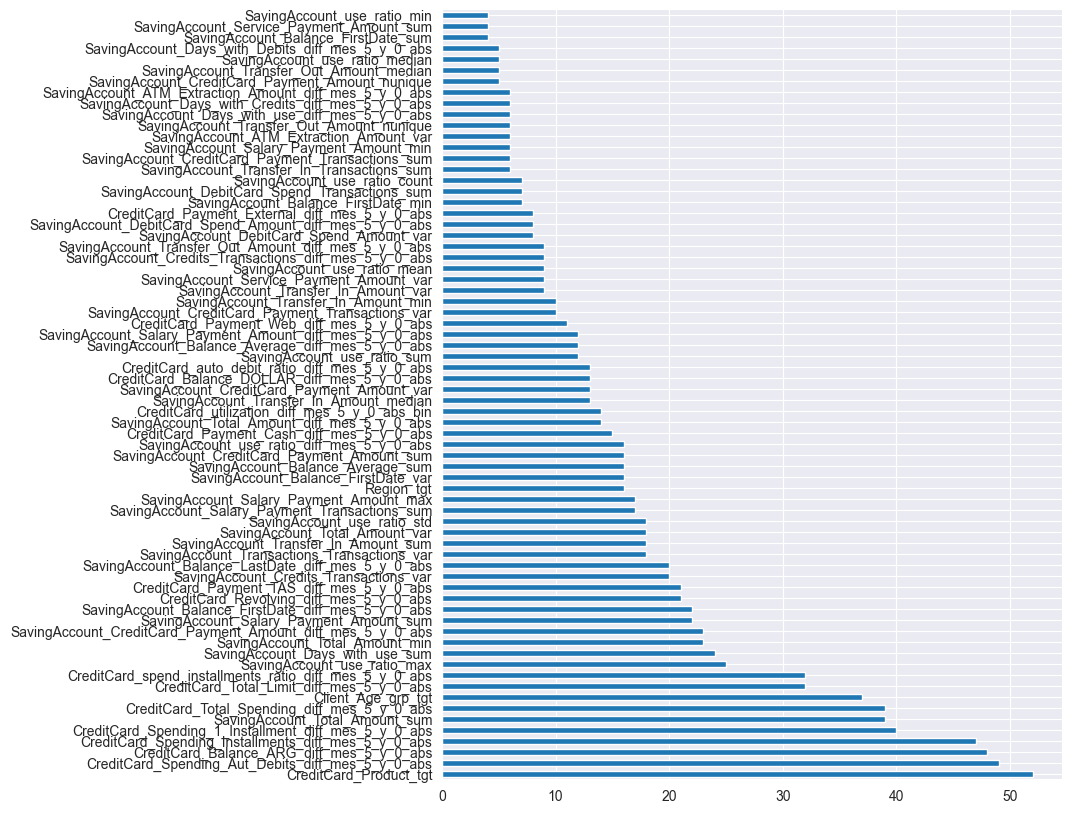

In [730]:
target_column = 'TGT'
numerical_cols = list(ABT.drop(['TGT', 'idx'], axis=1).columns)

# === fit_params: reemplazo early_stopping_rounds/verbose por callbacks ===
fit_params = {
    "eval_metric": "auc",
    "eval_set": [(X_test[numerical_cols], X_test[target_column])],
    "callbacks": [
        lgb.early_stopping(stopping_rounds=100, verbose=True),
        lgb.log_evaluation(period=100)
    ]
}

param_test = {
    'num_leaves': np.arange(10, 200, 10),         # más amplio
    'min_child_samples': np.arange(100, 2000, 200),
    'max_depth': np.arange(3, 20, 1),
    'n_estimators': np.arange(50, 800, 50),
    'learning_rate': np.logspace(-3, -1, 5),      # 0.001, 0.003, 0.01, 0.03, 0.1
    'subsample': np.linspace(0.5, 1.0, 6),
    'colsample_bytree': np.linspace(0.5, 1.0, 6)
}

# This parameter defines the number of HP points to be tested
n_HP_points_to_test = 50

# n_estimators is set to a "large value". The actual number of trees build will depend on early stopping
clf = lgb.LGBMClassifier(
    random_state=314,
    n_jobs=-1,
    device='gpu',
    boosting_type='gbdt',
    verbosity=-1
)

cross_val = StratifiedKFold(n_splits=3)

gs = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_test,
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=cross_val,
    refit=True,
    random_state=314,
    verbose=True
)

gs.fit(X_train[numerical_cols], X_train[target_column], **fit_params)

feat_imp = pd.Series(
    gs.best_estimator_.feature_importances_,
    index=X_train[numerical_cols].columns
)
feat_imp.nlargest(70).plot(kind='barh', figsize=(8,10))


In [731]:
len(numerical_cols)

95

In [732]:
feat_imp

Client_Age_grp_tgt                                        37
Region_tgt                                                16
CreditCard_Product_tgt                                    52
SavingAccount_Balance_FirstDate_sum                        4
SavingAccount_Balance_FirstDate_min                        7
                                                          ..
CreditCard_Payment_TAS_diff_mes_5_y_0_abs                 21
CreditCard_utilization_diff_mes_5_y_0_abs                  0
CreditCard_spend_installments_ratio_diff_mes_5_y_0_abs    32
CreditCard_auto_debit_ratio_diff_mes_5_y_0_abs            13
CreditCard_utilization_diff_mes_5_y_0_abs_bin             14
Length: 95, dtype: int32

In [733]:

opt_parameters = gs.best_estimator_.get_params()
print(opt_parameters)

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': np.float64(0.6), 'importance_type': 'split', 'learning_rate': np.float64(0.1), 'max_depth': np.int64(4), 'min_child_samples': np.int64(100), 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': np.int64(750), 'n_jobs': -1, 'num_leaves': np.int64(40), 'objective': None, 'random_state': 314, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': np.float64(0.8), 'subsample_for_bin': 200000, 'subsample_freq': 0, 'device': 'gpu', 'verbosity': -1}


In [734]:
gs.best_estimator_

,boosting_type,'gbdt'
,num_leaves,np.int64(40)
,max_depth,np.int64(4)
,learning_rate,np.float64(0.1)
,n_estimators,np.int64(750)
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,np.int64(100)


In [735]:
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Best score reached: 0.8305137452997728 with params: {'subsample': np.float64(0.8), 'num_leaves': np.int64(40), 'n_estimators': np.int64(750), 'min_child_samples': np.int64(100), 'max_depth': np.int64(4), 'learning_rate': np.float64(0.1), 'colsample_bytree': np.float64(0.6)} 


In [736]:

opt_parameters = gs.best_estimator_.get_params()
print(opt_parameters)

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': np.float64(0.6), 'importance_type': 'split', 'learning_rate': np.float64(0.1), 'max_depth': np.int64(4), 'min_child_samples': np.int64(100), 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': np.int64(750), 'n_jobs': -1, 'num_leaves': np.int64(40), 'objective': None, 'random_state': 314, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': np.float64(0.8), 'subsample_for_bin': 200000, 'subsample_freq': 0, 'device': 'gpu', 'verbosity': -1}


In [737]:

clf_final = lgb.LGBMClassifier(**clf.get_params())
print(clf.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 314, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'device': 'gpu', 'verbosity': -1}


In [738]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# === 1️⃣ Recuperar el mejor modelo ya entrenado ===
best_model = gs.best_estimator_
print("Best hyperparameters found:", gs.best_params_)
print(f"Best mean AUC (CV): {gs.best_score_:.4f}")

# === 2️⃣ Evaluar en tu conjunto de test ===
y_true = X_test[target_column]
X_eval = X_test[numerical_cols]

# Predicciones
y_pred = best_model.predict(X_eval)
y_prob = best_model.predict_proba(X_eval)[:, 1]

# === 3️⃣ Calcular métricas ===
accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)
auc       = roc_auc_score(y_true, y_prob)

# === 4️⃣ Mostrar resultados ===
print("\n📊 Model Performance on Test Set")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

Best hyperparameters found: {'subsample': np.float64(0.8), 'num_leaves': np.int64(40), 'n_estimators': np.int64(750), 'min_child_samples': np.int64(100), 'max_depth': np.int64(4), 'learning_rate': np.float64(0.1), 'colsample_bytree': np.float64(0.6)}
Best mean AUC (CV): 0.8305

📊 Model Performance on Test Set
Accuracy : 0.7688
Precision: 0.6468
Recall   : 0.4714
F1 Score : 0.5454
AUC      : 0.8345

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.89      0.84      4911
         1.0       0.65      0.47      0.55      2047

    accuracy                           0.77      6958
   macro avg       0.72      0.68      0.70      6958
weighted avg       0.76      0.77      0.76      6958



## Se ejecuta de nuevo con las mejores 30 features

CreditCard_Product_tgt                                        52
CreditCard_Spending_Aut_Debits_diff_mes_5_y_0_abs             49
CreditCard_Balance_ARG_diff_mes_5_y_0_abs                     48
CreditCard_Spending_Installments_diff_mes_5_y_0_abs           47
CreditCard_Spending_1_Installment_diff_mes_5_y_0_abs          40
SavingAccount_Total_Amount_sum                                39
CreditCard_Total_Spending_diff_mes_5_y_0_abs                  39
Client_Age_grp_tgt                                            37
CreditCard_Total_Limit_diff_mes_5_y_0_abs                     32
CreditCard_spend_installments_ratio_diff_mes_5_y_0_abs        32
SavingAccount_use_ratio_max                                   25
SavingAccount_Days_with_use_sum                               24
SavingAccount_Total_Amount_min                                23
SavingAccount_CreditCard_Payment_Amount_diff_mes_5_y_0_abs    23
SavingAccount_Salary_Payment_Amount_sum                       22
SavingAccount_Balance_Fir

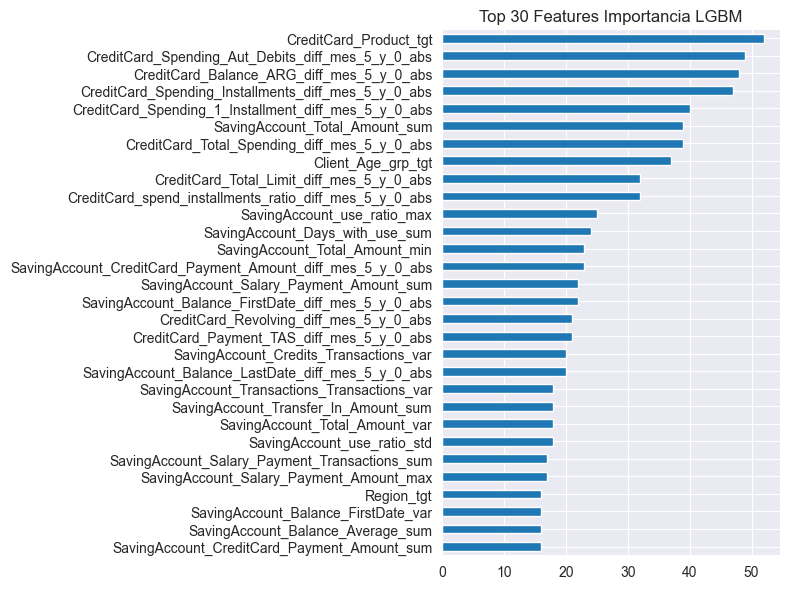

In [739]:
# === Top 33 features por importancia ya calculada en feat_imp ===
top30 = feat_imp.nlargest(30)                 # Serie: index=feature, values=importance
numerical_cols = top30.index.tolist()         # <-- nombres de columnas (no los valores)

print(top30)
ax = top30.plot(kind='barh', figsize=(8,6), title='Top 30 Features Importancia LGBM')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

# === Alinear X_train / X_test a esas 30 columnas (por si falta alguna) ===
X_train_top = X_train.reindex(columns=numerical_cols, fill_value=0)
X_test_top  = X_test.reindex(columns=numerical_cols,  fill_value=0)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.830577	valid_0's binary_logloss: 0.446221
Did not meet early stopping. Best iteration is:
[75]	valid_0's auc: 0.831408	valid_0's binary_logloss: 0.445237
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.830766	valid_0's binary_logloss: 0.444013
Did not meet early stopping. Best iteration is:
[61]	valid_0's auc: 0.832046	valid_0's binary_logloss: 0.443438
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.830792	valid_0's binary_logloss: 0.445102
Did not meet early stopping. Best iteration is:
[82]	valid_0's auc: 0.831501	valid_0's binary_logloss: 0.444224
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.819418	valid_0's binary_logloss: 0.460531
[200]	valid_0's auc: 0.823969	valid_0's binary_logloss: 0.452911
[300]	valid_0's auc: 0.825207

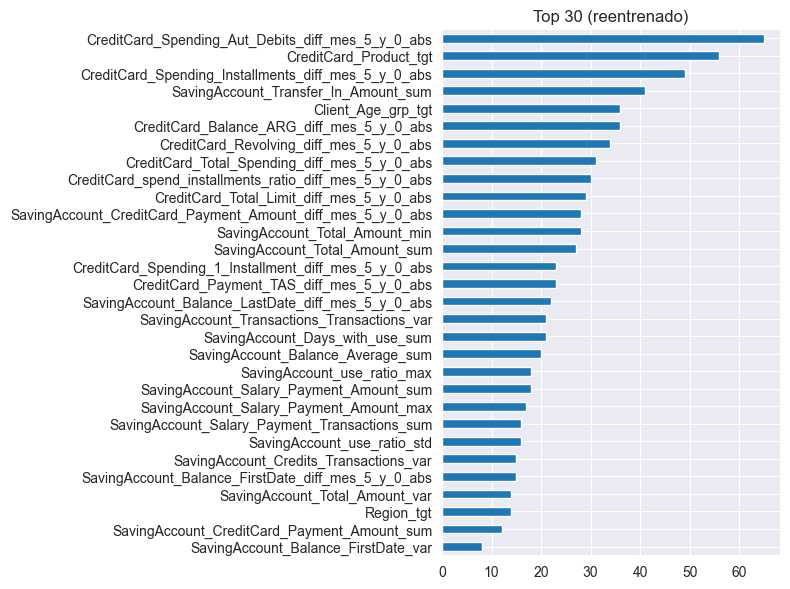

In [740]:
target_column = 'TGT'

fit_params = {
    "eval_metric": "auc",
    "eval_set": [(X_test_top, X_test[target_column])],
    "callbacks": [
        lgb.early_stopping(stopping_rounds=100, verbose=True),
        lgb.log_evaluation(period=100)
    ]
}

param_test = {
    'num_leaves': np.arange(10, 200, 10),         # más amplio
    'min_child_samples': np.arange(100, 2000, 200),
    'max_depth': np.arange(3, 20, 1),
    'n_estimators': np.arange(50, 800, 50),
    'learning_rate': np.logspace(-3, -1, 5),      # 0.001, 0.003, 0.01, 0.03, 0.1
    'subsample': np.linspace(0.5, 1.0, 6),
    'colsample_bytree': np.linspace(0.5, 1.0, 6)
}

n_HP_points_to_test = 50

clf = lgb.LGBMClassifier(
    random_state=314,
    n_jobs=-1,
    device='gpu',
    boosting_type='gbdt',
    verbosity=-1
)

cross_val = StratifiedKFold(n_splits=3)

gs = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_test,
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=cross_val,
    refit=True,
    random_state=314,
    verbose=True
)

gs.fit(X_train_top, X_train[target_column], **fit_params)

feat_imp_top = pd.Series(gs.best_estimator_.feature_importances_, index=numerical_cols)

ax = feat_imp_top.nlargest(30).plot(kind='barh', figsize=(8,6), title='Top 30 (reentrenado)')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [741]:
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Best score reached: 0.8304199655429981 with params: {'subsample': np.float64(0.8), 'num_leaves': np.int64(10), 'n_estimators': np.int64(100), 'min_child_samples': np.int64(300), 'max_depth': np.int64(12), 'learning_rate': np.float64(0.1), 'colsample_bytree': np.float64(0.8)} 


In [742]:
opt_parameters = gs.best_estimator_.get_params()
print(opt_parameters)

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': np.float64(0.8), 'importance_type': 'split', 'learning_rate': np.float64(0.1), 'max_depth': np.int64(12), 'min_child_samples': np.int64(300), 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': np.int64(100), 'n_jobs': -1, 'num_leaves': np.int64(10), 'objective': None, 'random_state': 314, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': np.float64(0.8), 'subsample_for_bin': 200000, 'subsample_freq': 0, 'device': 'gpu', 'verbosity': -1}


In [743]:
clf_final.set_params(**opt_parameters)

clf_final_train = clf_final.fit(X_train[numerical_cols], X_train[target_column],
                                **fit_params )

print(clf_final_train.best_score_)

feat_imp = pd.Series(clf_final.feature_importances_, index=X_train[numerical_cols].columns)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.833791	valid_0's binary_logloss: 0.441541
Did not meet early stopping. Best iteration is:
[87]	valid_0's auc: 0.833883	valid_0's binary_logloss: 0.441464
defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict({'auc': np.float64(0.8338833284242616), 'binary_logloss': np.float64(0.4414637634630361)})})


CreditCard_Spending_Aut_Debits_diff_mes_5_y_0_abs             65
CreditCard_Product_tgt                                        56
CreditCard_Spending_Installments_diff_mes_5_y_0_abs           49
SavingAccount_Transfer_In_Amount_sum                          41
CreditCard_Balance_ARG_diff_mes_5_y_0_abs                     36
Client_Age_grp_tgt                                            36
CreditCard_Revolving_diff_mes_5_y_0_abs                       34
CreditCard_Total_Spending_diff_mes_5_y_0_abs                  31
CreditCard_spend_installments_ratio_diff_mes_5_y_0_abs        30
CreditCard_Total_Limit_diff_mes_5_y_0_abs                     29
SavingAccount_Total_Amount_min                                28
SavingAccount_CreditCard_Payment_Amount_diff_mes_5_y_0_abs    28
SavingAccount_Total_Amount_sum                                27
CreditCard_Spending_1_Installment_diff_mes_5_y_0_abs          23
CreditCard_Payment_TAS_diff_mes_5_y_0_abs                     23
dtype: int32


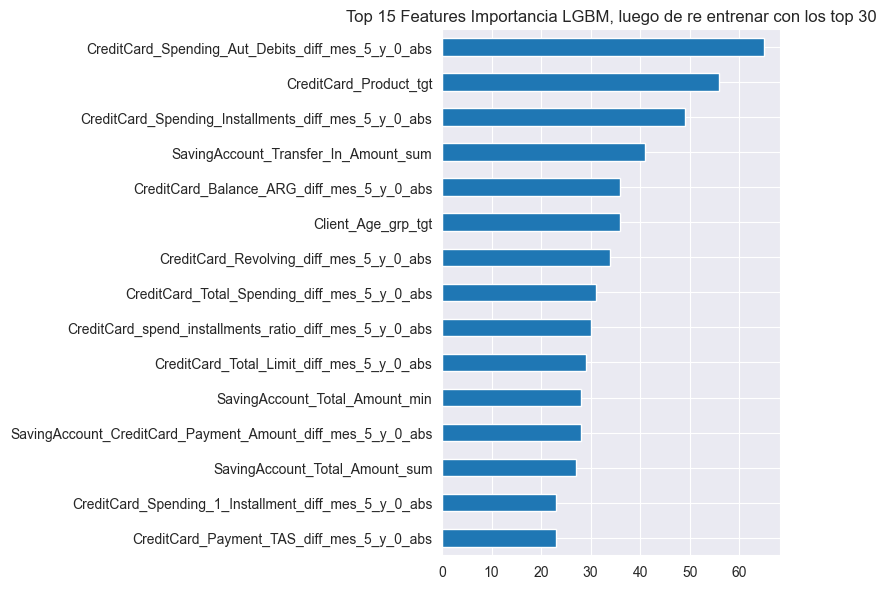

In [744]:
# === Top 15 features por importancia ya calculada en feat_imp ===
top15 = feat_imp.nlargest(15)                 # Serie: index=feature, values=importance       # <-- nombres de columnas (no los valores)

print(top15)
ax = top15.plot(kind='barh', figsize=(8,6), title='Top 15 Features Importancia LGBM, luego de re entrenar con los top 30')
ax.invert_yaxis()
plt.tight_layout()
plt.show()


Top 10 features:
 CreditCard_Spending_Aut_Debits_diff_mes_5_y_0_abs         65
CreditCard_Product_tgt                                    56
CreditCard_Spending_Installments_diff_mes_5_y_0_abs       49
SavingAccount_Transfer_In_Amount_sum                      41
CreditCard_Balance_ARG_diff_mes_5_y_0_abs                 36
Client_Age_grp_tgt                                        36
CreditCard_Revolving_diff_mes_5_y_0_abs                   34
CreditCard_Total_Spending_diff_mes_5_y_0_abs              31
CreditCard_spend_installments_ratio_diff_mes_5_y_0_abs    30
CreditCard_Total_Limit_diff_mes_5_y_0_abs                 29
dtype: int32


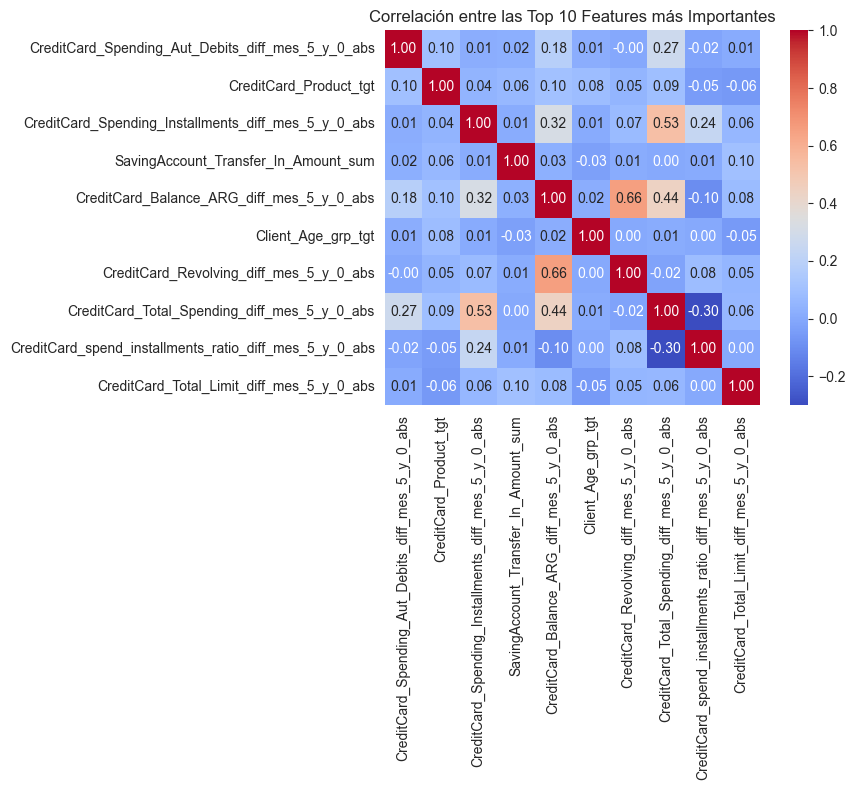

In [745]:
top10 = feat_imp.nlargest(10)

print("\nTop 10 features:\n", top10)

# === 4️⃣ Matriz de correlación entre las top 10 ===
top10_cols = top10.index.tolist()
corr = X_train[top10_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlación entre las Top 10 Features más Importantes')
plt.tight_layout()
plt.show()

In [746]:
# === 1️⃣ Recuperar el mejor modelo ya entrenado ===
best_model = gs.best_estimator_
print("Best hyperparameters found:", gs.best_params_)
print(f"Best mean AUC (CV): {gs.best_score_:.4f}")

feature_cols = list(X_train_top.columns)

# === 2️⃣ Evaluar en tu conjunto de test ===
X_eval = X_test[feature_cols].copy()      # mismas columnas y orden
y_true = X_test[target_column]

# Predicciones
y_pred = best_model.predict(X_eval)
y_prob = best_model.predict_proba(X_eval)[:, 1]

# === 3️⃣ Calcular métricas ===
accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)
auc       = roc_auc_score(y_true, y_prob)

# === 4️⃣ Mostrar resultados ===
print("\n📊 Model Performance on Test Set")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

Best hyperparameters found: {'subsample': np.float64(0.8), 'num_leaves': np.int64(10), 'n_estimators': np.int64(100), 'min_child_samples': np.int64(300), 'max_depth': np.int64(12), 'learning_rate': np.float64(0.1), 'colsample_bytree': np.float64(0.8)}
Best mean AUC (CV): 0.8304

📊 Model Performance on Test Set
Accuracy : 0.7734
Precision: 0.6528
Recall   : 0.4905
F1 Score : 0.5601
AUC      : 0.8339

Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.89      0.85      4911
         1.0       0.65      0.49      0.56      2047

    accuracy                           0.77      6958
   macro avg       0.73      0.69      0.70      6958
weighted avg       0.76      0.77      0.76      6958

